In [ ]:
from groq import Groq
import json
import pandas as pd    
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
import tqdm
import os
import numpy as np
import json
import concurrent.futures
import numpy as np
from tqdm import tqdm
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


In [ ]:
client = Groq(api_key="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") 
api_keys=["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", "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", "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", "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"] #get multiple API keys with different Email addresses, you will run into rate limits a lot so either slow down the requests or let lots of api keys handle the job
api_keyover=0

In [ ]:
from nilmtk.dataset import DataSet

redd = DataSet('redd.h5')

building = redd.buildings[1]

main_meter = building.elec.mains()

fridge_meter = building.elec['fridge']

main_df = main_meter.power_series_all_data().to_frame(name='total_power')
fridge_df = fridge_meter.power_series_all_data().to_frame(name='fridge_power')

df = pd.concat([main_df, fridge_df], axis=1)
df = df.dropna()
df.reset_index(inplace=True)
df.columns = ['timestamp', 'total_power', 'fridge_power']

In [ ]:
df

In [ ]:
fridge = df['fridge_power'][13632:34905].to_numpy()
time = [i for i in range(13632, 34905)]

time = np.array(time)
plt.plot(time, fridge)


In [ ]:

subset_df = df[13632:34905].reset_index(drop=True)

series = pd.Series(subset_df['timestamp'])

# Function to extract HH:MM
def extract_time(datetime_str):
    return pd.to_datetime(datetime_str).strftime('%H:%M')

# Apply the function to the Series
time_series = series.apply(extract_time)

subset_df['timestamp'] = time_series
result_df = subset_df.groupby('timestamp', as_index=False).mean()

fridge = result_df['fridge_power'].to_numpy()
time = [i for i in range(0, 1346)]

time = np.array(time)
plt.plot(time, fridge)

In [ ]:
combinationstorun=[[0,15]]
model = 'llama3-70b-8192'

### Zeroshots

In [ ]:
i = 0
# Mock function to simulate API calls
def promptgroq(csv, start_idx, chunksize, model, num_samples):
    answers = {'timestamps': [], 'predictions': []}
    attempts = 40
    predictions = []
    global api_keyover, client, i

    def get_prediction(run, csv=csv, start_idx=start_idx, chunksize=chunksize, model=model):
        global i, api_keyover, client
        while i < attempts:
            try:
                completion = client.chat.completions.create(
                    model='llama3-8b-8192',
                    messages=[
                        {
                            "role": "system",
                            "content": """You are a helpful assistant that performs time series predictions for NILM (Non-Intrusive Load Monitoring). The user will provide an aggregate data sequence of power consumption with timestamps for a day, and you will predict the power consumption of the fridge corresponding to each timestamp in the data. The sequence is represented by decimal strings separated by commas for power values and ISO 8601 format for timestamps.
                                            DO NOT CHANGE THE TIMESTAMPS KEEP THEM SAME AS IN THE DATA.
                                            Keep in mind the other appliances.
                                            Appliance Information:
                                            Low power consuming appliances - Lighting, Electronics, Fridge
                                            Moderate power consuming appliances - Bathroom GFI, Dishwasher, Microwave, Kitchen Outlets
                                            High power consuming appliances - Washer Dryer   
                                        """
                        },
                        {
                            "role": "user",
                            "content": f"""Predict the fridge power consumption for the given time series data for the next {chunksize} timestamps. Each timestamp in the input should have a corresponding output. Return your reply in the following format:
                                            [timestamp 0, prediction 0, timestamp 1, prediction 1, ..., timestamp {chunksize - 1}, prediction {chunksize - 1}] - the total length should be exactly {chunksize * 2}, starting from timestamp {start_idx} until the timestamp {start_idx + chunksize - 1}. Do not include any additional text or explanations.
                                            
                                            ### Time Series Data
                                            {csv}
                                            """
                        }
                    ],
                    temperature=1,
                    top_p=1,
                    stream=False,
                    stop=None,
                )
            except Exception as e:
                print('API key limit reached', e)
                api_keyover += 1
                client = Groq(api_key=api_keys[api_keyover % 4])
                continue

            try:
                answer = completion.choices[0].message.content.strip()
                predictions_list = [item.strip() for item in answer.split(',') if item.strip()]

                pred_timestamps = predictions_list[::2]
                pred_values_str = predictions_list[1::2]

                pred_values_cleaned = []
                for value in pred_values_str:
                    try:
                        pred_values_cleaned.append(float(value))
                    except ValueError:
                        float_part = ''.join([char for char in value if char.isdigit() or char == '.' or char == '-'])
                        pred_values_cleaned.append(float(float_part))

                pred_df = pd.DataFrame({
                    'timestamp': [ts.strip() for ts in pred_timestamps],
                    'predicted_fridge_power': pred_values_cleaned
                })

                if len(pred_timestamps) == chunksize:
                    return pred_df
                else:
                    i += 1
            except Exception as e:
                i += 1
                continue

        return None

    with concurrent.futures.ThreadPoolExecutor() as executor:
        future_to_run = {executor.submit(get_prediction, run): run for run in range(num_samples)}
        for future in tqdm(concurrent.futures.as_completed(future_to_run)):
            result = future.result()
            if result is not None:
                predictions.append(result)

    if len(predictions) < num_samples:
        return promptgroq(csv, start_idx, chunksize, model, num_samples)

    for i in range(chunksize):
        sum = 0
        for j in range(num_samples):
            sum += predictions[j]['predicted_fridge_power'][i]
        answers['predictions'].append(sum / num_samples)
        answers['timestamps'].append(predictions[0]['timestamp'][i])

    return answers


In [ ]:
pred_df_list = []
# Run the loop
for start_idx, chunksize in combinationstorun:
    for start in tqdm(range(0, len(result_df) - (start_idx + chunksize), 15)):
        current_chunk = result_df.iloc[start:start+start_idx+chunksize]
        input_string = current_chunk[['timestamp', 'total_power']].to_csv(index=False, header=False)
        input_string = input_string.replace(" ", "").replace('\n', ',').replace(',', ' , ')
        answer = promptgroq(input_string, start + start_idx, chunksize, model, num_samples=2)
        predictions = answer['predictions']
        timestamps = answer['timestamps']
        predicted_df = pd.DataFrame({'Timestamp': timestamps, 'Fridge_power': predictions})
        print(predicted_df)
        pred_df_list.append(predicted_df)

### Caluclating Error

In [ ]:
len(pred_df_list)

In [ ]:

# Function to plot results and calculate MSE
def plot_results(real_values, predicted_values):
    
    print('PREDICTED',len(predicted_values))
    min_length = min(len(real_values), len(predicted_values))
    real_values = real_values[:min_length]
    predicted_values = predicted_values[:min_length]

    mask = ~np.isnan(real_values) & ~np.isnan(predicted_values)
    real_values = real_values[mask]
    predicted_values = predicted_values[mask]

    mse = mean_squared_error(real_values, predicted_values)
    print(f"MSE Loss: {mse}")

    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.plot(real_values, label='Real Fridge Power')
    plt.plot(predicted_values, label='Predicted Fridge Power')
    plt.xlabel('Index')
    plt.ylabel('Fridge Power')
    plt.title('Real vs Predicted Fridge Power')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
df_1 = pd.concat(pred_df_list, ignore_index=True)

# Assuming all_pred_df is defined elsewhere and contains the predicted values
all_pred_df = df_1.copy()  # Placeholder, replace with actual predicted values DataFrame

# Extract real and predicted fridge power
real_fridge_power = result_df['fridge_power'].values
predicted_fridge_power = all_pred_df['Fridge_power'].values

print(len(real_fridge_power))
print('PREDICTED',len(predicted_fridge_power))
# Plot results and calculate MSE
plot_results(real_fridge_power, predicted_fridge_power)


### Fewshots

In [ ]:

i=0
# Mock function to simulate API calls
def promptgroq_fewshots(csv, start_idx, chunksize, model, num_samples, initial_examples):
    answers = {'timestamps': [], 'predictions': []}
    attempts = 40
    predictions = []
    global api_keyover, client, i

    initial_examples_str = ", ".join(
    [f"Timestamp: {row['timestamp']}, Total Power: {row['total_power']}, Fridge Power: {row['fridge_power']}"
     for idx, row in initial_examples.iterrows()]
)


    def get_prediction(run, csv=csv, start_idx=start_idx, chunksize=chunksize, model=model):
        global i, api_keyover, client
        while i < attempts:
            try:
                completion = client.chat.completions.create(
                    model='llama3-8b-8192',
                    messages=[
                        # {
                        #     "role": "system",
                        #     "content": """You are a helpful assistant that performs time series predictions for NILM (Non-Intrusive Load Monitoring). The user will provide an aggregate data sequence of power consumption and timestamps with a few examples of power consumed by fridge, and you will predict the power consumption of the fridge corresponding to each timestamp in the data. The sequence is represented by decimal strings separated by commas for power values and ISO 8601 format for timestamps.
                                            
                        #                     DO NOT CHANGE THE TIMESTAMPS KEEP THEM SAME AS IN THE DATA.
                        #                     Fridge consumes a low amount of the aggregate power so predict accordingly. Also keep in mind the other appliances.
                        #                     Appliance Information:
                        #                     Low power consuming appliances - Lighting, Electronics, Fridge
                        #                     Moderate power consuming appliances - Bathroom GFI, Dishwasher, Microwave, Kitchen Outlets
                        #                     High power consuming appliances - Washer Dryer   
                        #                 """
                        # },
                        # {
                        #     "role": "user",
                        #     "content": f"""Predict the fridge power consumption for the given time series data for the next {chunksize} timestamps. Each timestamp in the input should have a corresponding output. Return your reply in the following format:
                        #                     [timestamp 0, prediction 0, timestamp 1, prediction 1, ..., timestamp {chunksize - 1}, prediction {chunksize - 1}] - the total length should be exactly {chunksize * 2}, starting from timestamp {start_idx} until the timestamp {start_idx + chunksize - 1}. Do not include any additional text or explanations.
                                            
                        #                     ### Initial Examples
                        #                     {initial_examples_str}

                        #                     ### Time Series Data
                        #                     {csv}
                        #                     """
                        # }
                        {
                            "role": "system",
                            "content": """You are a helpful assistant that performs time series predictions for NILM (Non-Intrusive Load Monitoring). The user will provide an aggregate data sequence of power consumption and timestamps with a few examples of power consumed by fridge, and you will predict the power consumption of the fridge corresponding to each timestamp in the data. The sequence is represented by decimal strings separated by commas for power values and ISO 8601 format for timestamps 
                                            DO NOT CHANGE THE TIMESTAMPS KEEP THEM SAME AS IN THE DATA. USE EXAMPLE STRING PROVIDED AS A TRAINING SET
                                            Fridge consumes a low amount of the aggregate power so predict accordingly. Also keep in mind the other appliances.
                                            Appliance Information:
                                            Low power consuming appliances - Lighting, Electronics, Fridge
                                            Moderate power consuming appliances - Bathroom GFI, Dishwasher, Microwave, Kitchen Outlets
                                            High power consuming appliances - Washer Dryer   
                                        """
                        },
                        {
                            "role": "user",
                            "content": f"""Predict the fridge power consumption for the given time series data for the next {chunksize} timestamps by using the examples provided. Each timestamp in the input should have a corresponding output. Return your reply in the following format:
                                            [timestamp 0, prediction 0, timestamp 1, prediction 1, ..., timestamp {chunksize - 1}, prediction {chunksize - 1}] - the total length should be exactly {chunksize * 2}, starting from timestamp {start_idx} until the timestamp {start_idx + chunksize - 1}. Do not include any additional text or explanations.
                                            
                                            ### Initial Examples
                                            {initial_examples_str}
                                            
                                            ### Time Series Data
                                            {csv}
                                            """
                        }
                    ],
                    temperature=1,
                    top_p=1,
                    stream=False,
                    stop=None,
                )
            except Exception as e:
                print('API key limit reached', e)
                api_keyover += 1
                client = Groq(api_key=api_keys[api_keyover % 4])
                continue

            try:
                answer = completion.choices[0].message.content.strip()
                predictions_list = [item.strip() for item in answer.split(',') if item.strip()]

                pred_timestamps = predictions_list[::2]
                pred_values_str = predictions_list[1::2]

                pred_values_cleaned = []
                for value in pred_values_str:
                    try:
                        pred_values_cleaned.append(float(value))
                    except ValueError:
                        float_part = ''.join([char for char in value if char.isdigit() or char == '.' or char == '-'])
                        pred_values_cleaned.append(float(float_part))

                pred_df = pd.DataFrame({
                    'timestamp': [ts.strip() for ts in pred_timestamps],
                    'predicted_fridge_power': pred_values_cleaned
                })

                if len(pred_timestamps) == chunksize:
                    return pred_df
                else:
                    i += 1
            except Exception as e:
                i += 1
                continue

        return None

    with concurrent.futures.ThreadPoolExecutor() as executor:
        future_to_run = {executor.submit(get_prediction, run): run for run in range(num_samples)}
        for future in tqdm(concurrent.futures.as_completed(future_to_run)):
            result = future.result()
            if result is not None:
                predictions.append(result)

    if len(predictions) < num_samples:
        return promptgroq(csv, start_idx, chunksize, model, num_samples, initial_examples)

    for i in range(chunksize):
        sum = 0
        for j in range(num_samples):
            sum += predictions[j]['predicted_fridge_power'][i]
        answers['predictions'].append(sum / num_samples)
        answers['timestamps'].append(predictions[0]['timestamp'][i])

    return answers




In [ ]:
train_df = result_df[:60]
test_df = result_df[60:]
pred_df_list = []

# Select a small set of initial examples (e.g., first 5 rows)
initial_examples = train_df[['timestamp', 'total_power', 'fridge_power']]

In [ ]:
# Run the loop
for start_idx, chunksize in combinationstorun:
    for start in tqdm(range(0, len(test_df) - (start_idx + chunksize), 15)):
        current_chunk = test_df.iloc[start:start+start_idx+chunksize]
        input_string = current_chunk[['timestamp', 'total_power']].to_csv(index=False, header=False)
        input_string = input_string.replace(" ", "").replace('\n', ',').replace(',', ' , ')
        answer = promptgroq_fewshots(input_string, start + start_idx, chunksize, model, num_samples=2, initial_examples=initial_examples)
        predictions = answer['predictions']
        timestamps = answer['timestamps']
        predicted_df = pd.DataFrame({'Timestamp': timestamps, 'Fridge_power': predictions})
        print(predicted_df)
        pred_df_list.append(predicted_df)

In [ ]:

all_pred_df = pd.concat(pred_df_list, ignore_index=True)

real_fridge_power = df['fridge_power'][:len(all_pred_df)].values

predicted_fridge_power = all_pred_df['Fridge_power'].values

plot_results(real_fridge_power, predicted_fridge_power)

In [2]:
client = Groq(api_key="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") 
api_keys=["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", "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", "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", "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"] #get multiple API keys with different Email addresses, you will run into rate limits a lot so either slow down the requests or let lots of api keys handle the job
api_keyover=0

In [29]:
df

,timestamp,total_power,fridge_power
0,2011-04-18 09:22:13-04:00,341.029999,6.0
1,2011-04-18 09:22:16-04:00,342.359985,6.0
2,2011-04-18 09:22:20-04:00,342.520020,6.0
3,2011-04-18 09:22:23-04:00,342.070007,6.0
4,2011-04-18 09:22:26-04:00,341.770020,6.0
...,...,...,...
410090,2011-05-24 15:56:20-04:00,274.380005,186.0
410091,2011-05-24 15:56:23-04:00,273.690002,187.0
410092,2011-05-24 15:56:27-04:00,274.070007,190.0
410093,2011-05-24 15:56:30-04:00,274.750000,189.0


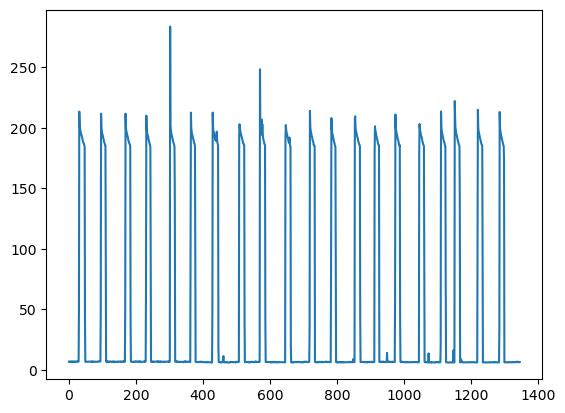

In [4]:

subset_df = df[13632:34905].reset_index(drop=True)

series = pd.Series(subset_df['timestamp'])

# Function to extract HH:MM
def extract_time(datetime_str):
    return pd.to_datetime(datetime_str).strftime('%H:%M')

# Apply the function to the Series
time_series = series.apply(extract_time)

subset_df['timestamp'] = time_series
result_df = subset_df.groupby('timestamp', as_index=False).mean()

fridge = result_df['fridge_power'].to_numpy()
time = [i for i in range(0, 1346)]

time = np.array(time)
plt.plot(time, fridge)

### Zeroshots

In [41]:
pred_df_list = []
# Run the loop
for start_idx, chunksize in combinationstorun:
    for start in tqdm(range(0, len(result_df) - (start_idx + chunksize), 15)):
        current_chunk = result_df.iloc[start:start+start_idx+chunksize]
        input_string = current_chunk[['timestamp', 'total_power']].to_csv(index=False, header=False)
        input_string = input_string.replace(" ", "").replace('\n', ',').replace(',', ' , ')
        answer = promptgroq(input_string, start + start_idx, chunksize, model, num_samples=2)
        predictions = answer['predictions']
        timestamps = answer['timestamps']
        predicted_df = pd.DataFrame({'Timestamp': timestamps, 'Fridge_power': predictions})
        print(predicted_df)
        pred_df_list.append(predicted_df)

2it [00:02,  1.36s/it][00:00<?, ?it/s]
  1%|          | 1/89 [00:02<04:02,  2.76s/it]

   Timestamp  Fridge_power
0     [00:00     97.433120
1      00:01     97.519770
2      00:02     96.951610
3      00:03     96.751025
4      00:04     96.308250
5      00:05     96.689125
6      00:06     96.557450
7      00:07     95.737915
8      00:08     95.518145
9      00:09     95.373270
10     00:10     96.843035
11     00:11     95.606990
12     00:12     93.999805
13     00:13     93.942260
14     00:14     94.323465


2it [00:08,  4.26s/it]
  2%|▏         | 2/89 [00:11<08:57,  6.18s/it]

   Timestamp  Fridge_power
0     [00:30    183.539425
1      00:31    183.194265
2      00:32    183.322290
3      00:33    183.588690
4      00:34    183.348225
5      00:35    182.584415
6      00:36    183.502325
7      00:37    183.395890
8      00:38    183.096675
9      00:39    182.684665
10     00:40    183.763075
11     00:41    182.401740
12     00:42    183.409290
13     00:43    183.132375
14     00:44    183.903815


2it [00:01,  1.20it/s]
  3%|▎         | 3/89 [00:13<05:55,  4.14s/it]

   Timestamp  Fridge_power
0     [00:30    184.462270
1      00:31    183.770900
2      00:32    183.329670
3      00:33    182.918175
4      00:34    182.486000
5      00:35    182.044665
6      00:36    181.637200
7      00:37    180.829740
8      00:38    180.362240
9      00:39    179.919700
10     00:40    179.498310
11     00:41    179.095670
12     00:42    178.684225
13     00:43    178.306620
14     00:44    177.940995


2it [00:01,  1.18it/s]
  4%|▍         | 4/89 [00:14<04:31,  3.19s/it]

   Timestamp  Fridge_power
0     [00:45    118.187940
1      00:46    118.403430
2      00:47    117.331060
3      00:48    105.476585
4      00:49    103.410765
5      00:50    103.153465
6      00:51    102.984385
7      00:52    103.501325
8      00:53    104.354040
9      00:54    103.948775
10     00:55    103.227595
11     00:56    103.469555
12     00:57    104.492975
13     00:58    104.093585
14     00:59    104.174240


2it [00:05,  2.99s/it]
  6%|▌         | 5/89 [00:20<05:53,  4.21s/it]

    Timestamp  Fridge_power
0   [01:00 60    130.935960
1    01:01 61    130.039905
2    01:02 62    130.230835
3    01:03 63    128.416670
4    01:04 64    129.654990
5    01:05 65    131.827035
6    01:06 66    129.692815
7    01:07 67    129.044790
8    01:08 68    128.803685
9    01:09 69    131.877655
10   01:10 70    130.522755
11   01:11 71    128.310815
12   01:12 72    128.712370
13   01:13 73    130.734785
14   01:14 74    130.627770


2it [00:13,  6.50s/it]
  7%|▋         | 6/89 [00:33<09:58,  7.22s/it]

   Timestamp  Fridge_power
0     [01:30    174.181250
1      01:31    173.946875
2      01:32    173.912500
3      01:33    174.368750
4      01:34    174.461250
5      01:35    173.917815
6      01:36    174.483750
7      01:37    175.051250
8      01:38    175.095000
9      01:39    174.123125
10     01:40    175.036875
11     01:41    173.920000
12     01:42    174.505000
13     01:43    174.653750
14     01:44    173.980000


2it [00:13,  6.50s/it]
  8%|▊         | 7/89 [00:46<12:27,  9.12s/it]

   Timestamp  Fridge_power
0        [90    191.287520
1         91    190.886520
2         92    190.484620
3         93    190.082670
4         94    189.680720
5         95    189.278770
6         96    189.271625
7         97    188.869675
8         98    188.467725
9         99    188.070775
10       100    187.673825
11       101    187.276875
12       102    186.879925
13       103    186.482975
14       104    186.086025


2it [00:10,  5.49s/it]
  9%|▉         | 8/89 [00:57<13:07,  9.72s/it]

   Timestamp  Fridge_power
0     [01:45     76.071700
1      01:46     77.565950
2      01:47     72.613400
3      01:48     74.560850
4      01:49     77.756500
5      01:50     82.337595
6      01:51     76.833005
7      01:52     78.342930
8      01:53     75.995925
9      01:54     77.985410
10     01:55     76.739945
11     01:56     79.738765
12     01:57     76.438065
13     01:58     78.539145
14     01:59     75.418175


2it [00:20, 10.01s/it]
 10%|█         | 9/89 [01:17<17:16, 12.96s/it]

   Timestamp  Fridge_power
0       [120        172.10
1        121        172.90
2        122        173.70
3        123        172.30
4        124        172.30
5        125        173.90
6        126        174.00
7        127        171.85
8        128        172.05
9        129        173.90
10       130        174.05
11       131        171.95
12       132        171.60
13       133        173.25
14       134        173.30


2it [00:07,  3.88s/it]
 11%|█         | 10/89 [01:25<14:57, 11.36s/it]

   Timestamp  Fridge_power
0     [02:30    106.270065
1      02:31    105.983590
2      02:32    106.600585
3      02:33    106.263985
4      02:34    105.925275
5      02:35    105.785915
6      02:36    106.408280
7      02:37    105.979370
8      02:38    105.747115
9      02:39    106.174760
10     02:40    105.554410
11     02:41    106.153280
12     02:42    105.835220
13     02:43    105.477565
14     02:44    105.981075


2it [00:17,  8.82s/it]
 12%|█▏        | 11/89 [01:43<17:17, 13.30s/it]

   Timestamp  Fridge_power
0     [02:30      17.28365
1      02:31      17.28365
2      02:32      17.28365
3      02:33      17.95625
4      02:34      17.28365
5      02:35      17.28365
6      02:36      16.56080
7      02:37      17.70620
8      02:38      17.44725
9      02:39      16.49145
10     02:40      17.28365
11     02:41      17.67295
12     02:42      17.28365
13     02:43      17.14240
14     02:44      17.15775


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on requests per minute (RPM): Limit 30, Used 30, Requested 1. Please try again in 1.882s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'requests', 'code': 'rate_limit_exceeded'}}


2it [00:19,  9.85s/it]
 13%|█▎        | 12/89 [02:03<19:34, 15.26s/it]

   Timestamp  Fridge_power
0       [165    211.781635
1        166    211.084760
2        167    216.217775
3        168    231.290000
4        169    320.829405
5        170    313.247395
6        171    310.271990
7        172    308.584760
8        173    308.479910
9        174    307.237025
10       175    307.349175
11       176    306.278160
12       177    304.957940
13       178    304.923160
14       179    303.613405


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on requests per minute (RPM): Limit 30, Used 30, Requested 1. Please try again in 1.117s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'requests', 'code': 'rate_limit_exceeded'}}


2it [00:16,  8.19s/it]
 15%|█▍        | 13/89 [02:19<19:49, 15.65s/it]

   Timestamp  Fridge_power
0     [03:15    130.399605
1      03:16    130.135060
2      03:17    130.157900
3      03:18    130.291195
4      03:19    130.008140
5      03:20    129.798055
6      03:21    129.798560
7      03:22    129.489595
8      03:23    129.497675
9      03:24    129.290255
10     03:25    129.160310
11     03:26    128.937895
12     03:27    128.699675
13     03:28    128.583960
14     03:29    128.465005


2it [00:10,  5.48s/it]
 16%|█▌        | 14/89 [02:30<17:48, 14.24s/it]

   Timestamp  Fridge_power
0     [03:30    173.725625
1      03:31    173.936940
2      03:32    173.633125
3      03:33    173.707500
4      03:34    173.931560
5      03:35    173.130000
6      03:36    173.445310
7      03:37    172.737655
8      03:38    172.993065
9      03:39    173.221875
10     03:40    172.330625
11     03:41    172.637812
12     03:42    172.335310
13     03:43    172.542440
14     03:44    171.814690


2it [00:05,  2.56s/it]
 17%|█▋        | 15/89 [02:35<14:11, 11.51s/it]

   Timestamp  Fridge_power
0      03:30     49.327050
1      03:31     49.671250
2      03:32     49.512000
3      03:33     49.346875
4      03:34     49.180315
5      03:35     48.414250
6      03:36     48.730440
7      03:37     48.522000
8      03:38     48.310815
9      03:39     48.101750
10     03:40     47.909940
11     03:41     47.719250
12     03:42     47.532065
13     03:43     47.347250
14     03:44     47.164690


2it [00:09,  4.54s/it]
 18%|█▊        | 16/89 [02:45<13:08, 10.80s/it]

   Timestamp  Fridge_power
0       [225           NaN
1        226           NaN
2        227           NaN
3        228           NaN
4        229    150.399060
5        230    149.653225
6        231    149.387850
7        232    149.194400
8        233    149.055110
9        234    148.962775
10       235    149.045425
11       236    149.129300
12       237    149.248700
13       238    149.454800
14       239    149.703400


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on requests per minute (RPM): Limit 30, Used 30, Requested 1. Please try again in 1.939s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'requests', 'code': 'rate_limit_exceeded'}}


2it [00:14,  7.01s/it]
 19%|█▉        | 17/89 [02:59<14:08, 11.78s/it]

   Timestamp  Fridge_power
0     [04:24    169.724455
1      04:25    169.534180
2      04:26    169.698685
3      04:27    169.832105
4      04:28    169.561805
5      04:29    169.716870
6      04:30    169.483020
7      04:31    169.797620
8      04:32    169.679805
9      04:33    169.586620
10     04:34    169.916890
11     04:35    169.651785
12     04:36    169.561890
13     04:37    169.785285
14     04:38    169.609055


2it [00:13,  6.62s/it]
 20%|██        | 18/89 [03:12<14:28, 12.23s/it]

   Timestamp  Fridge_power
0      04:15      158.4950
1      04:16      160.3700
2      04:17      158.8175
3      04:18      159.5735
4      04:19      160.5700
5      04:20      160.6150
6      04:21      160.4200
7      04:22      160.0050
8      04:23      160.5000
9      04:24      160.9350
10     04:25      160.5150
11     04:26      160.1100
12     04:27      160.1400
13     04:28      161.0400
14     04:29      160.7950


2it [00:19,  9.76s/it]
 21%|██▏       | 19/89 [03:31<16:50, 14.43s/it]

   Timestamp  Fridge_power
0     [04:30     73.378125
1      04:31     73.563750
2      04:32     73.724995
3      04:33     74.305315
4      04:34     73.582315
5      04:35     73.137375
6      04:36     72.440315
7      04:37     73.302250
8      04:38     72.606005
9      04:39     71.952500
10     04:40     71.580200
11     04:41     74.411900
12     04:42     71.477815
13     04:43     70.860625
14     04:44     70.895940


2it [00:09,  4.78s/it]
 22%|██▏       | 20/89 [03:41<14:55, 12.98s/it]

   Timestamp  Fridge_power
0       [285    175.314975
1        286    174.673495
2        287    174.470045
3        288    174.795500
4        289    175.333695
5        290    175.062495
6        291    176.733810
7        292    175.215345
8        293    175.029405
9        294    175.079905
10       295    175.845540
11       296    175.343385
12       297    174.958945
13       298    175.932740
14       299    175.207135


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on requests per minute (RPM): Limit 30, Used 30, Requested 1. Please try again in 1.738999999s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'requests', 'code': 'rate_limit_exceeded'}}


2it [00:22, 11.19s/it]
 24%|██▎       | 21/89 [04:03<17:55, 15.81s/it]

   Timestamp  Fridge_power
0       [300     44.862510
1        301     44.712375
2        302     44.839890
3        303     44.964840
4        304     45.093310
5        305     45.225960
6        306     45.362610
7        307     45.501445
8        308     45.643100
9        309     45.787695
10       310     45.935165
11       311     46.086410
12       312     46.240620
13       313     46.393380
14       314     46.547630


2it [00:22, 11.11s/it]
 25%|██▍       | 22/89 [04:26<19:49, 17.75s/it]

   Timestamp  Fridge_power
0     [16:45    169.657490
1      16:46    169.289360
2      16:47    169.217715
3      16:48    168.836485
4      16:49    168.628625
5      16:50    169.148710
6      16:51    169.019760
7      16:52    168.947655
8      16:53    169.578595
9      16:54    168.860110
10     16:55    168.983720
11     16:56    168.929330
12     16:57    169.240540
13     16:58    169.181230
14     16:59    169.041135


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on requests per minute (RPM): Limit 30, Used 30, Requested 1. Please try again in 1.545s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'requests', 'code': 'rate_limit_exceeded'}}


2it [00:13,  6.99s/it]
 26%|██▌       | 23/89 [04:40<18:17, 16.63s/it]

   Timestamp  Fridge_power
0     [06:30    155.916665
1      06:31    156.212500
2      06:32    158.270830
3      06:33    159.291665
4      06:34    157.591665
5      06:35    157.112500
6      06:36    155.920830
7      06:37    155.466665
8      06:38    154.508335
9      06:39    154.058335
10     06:40    154.262500
11     06:41    154.450000
12     06:42    153.466665
13     06:43    153.145835
14     06:44    153.395835


2it [00:04,  2.15s/it]
 27%|██▋       | 24/89 [04:44<14:01, 12.94s/it]

   Timestamp  Fridge_power
0       [345    174.131815
1        346    174.109850
2        347    174.106785
3        348    174.130135
4        349    175.021565
5        350    174.302500
6        351    173.928935
7        352    174.357435
8        353    174.808640
9        354    174.451775
10       355    174.027565
11       356    174.805465
12       357    174.184360
13       358    173.937695
14       359    174.226945


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on requests per minute (RPM): Limit 30, Used 30, Requested 1. Please try again in 1.935s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'requests', 'code': 'rate_limit_exceeded'}}
API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on requests per minute (RPM): Limit 30, Used 30, Requested 1. Please try again in 1.232s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'requests', 'code': 'rate_limit_exceeded'}}


2it [00:24, 12.25s/it]
 28%|██▊       | 25/89 [05:09<17:31, 16.42s/it]

   Timestamp  Fridge_power
0     [06:43    161.471453
1      06:44    160.769453
2      06:45    161.674398
3      06:46    161.067288
4      06:47    161.474278
5      06:48    160.787013
6      06:49    160.737478
7      06:50    161.592353
8      06:51    161.159628
9      06:52    160.837378
10     06:53    161.289928
11     06:54    161.742418
12     06:55    161.227428
13     06:56    162.137228
14     06:57    161.857478


2it [00:23, 11.70s/it]
 29%|██▉       | 26/89 [05:32<19:27, 18.53s/it]

   Timestamp  Fridge_power
0     [06:30    173.032115
1      06:31    172.624175
2      06:32    173.087175
3      06:33    172.544205
4      06:34    173.783245
5      06:35    172.855335
6      06:36    173.258430
7      06:37    172.526680
8      06:38    173.484345
9      06:39    172.630190
10     06:40    172.977255
11     06:41    172.309410
12     06:42    173.515110
13     06:43    173.039060
14     06:44    173.496550


2it [00:09,  4.76s/it]
 30%|███       | 27/89 [05:42<16:22, 15.84s/it]

   Timestamp  Fridge_power
0     [06:40     75.510540
1      06:41     74.801715
2      06:42     75.171825
3      06:43     74.515110
4      06:44     73.384225
5      06:45     73.300360
6      06:46     74.684990
7      06:47     74.068620
8      06:48     74.969255
9      06:49     76.359890
10     06:50     77.235520
11     06:51     78.131155
12     06:52     79.051790
13     06:53     79.932425
14     06:54     80.803055


2it [00:12,  6.42s/it]
 31%|███▏      | 28/89 [05:55<15:11, 14.95s/it]

   Timestamp  Fridge_power
0      06:45    196.134765
1      06:46    197.760435
2      06:47    201.387295
3      06:48    200.785415
4      06:49    200.768270
5      06:50    199.366595
6      06:51    198.755500
7      06:52    198.426080
8      06:53    195.449725
9      06:54    193.634240
10     06:55    193.218205
11     06:56    193.539450
12     06:57    193.116895
13     06:58    192.979525
14     06:59    192.998470


2it [00:07,  3.96s/it]
 33%|███▎      | 29/89 [06:02<12:51, 12.85s/it]

   Timestamp  Fridge_power
0     [07:20     128.44095
1      07:21     128.26800
2      07:22     128.28230
3      07:23     128.26090
4      07:24     228.40370
5      07:25     246.94285
6      07:26     247.91470
7      07:27     248.53910
8      07:28     248.95560
9      07:29     248.12205
10     07:30     247.50685
11     07:31     247.14105
12     07:32     246.87695
13     07:33     246.67730
14     07:34     246.56815


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on requests per minute (RPM): Limit 30, Used 30, Requested 1. Please try again in 1.898s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'requests', 'code': 'rate_limit_exceeded'}}


2it [00:56, 28.34s/it]
 34%|███▎      | 30/89 [06:59<25:35, 26.02s/it]

   Timestamp  Fridge_power
0     [07:29    366.963300
1      07:30    366.870165
2      07:31    370.780225
3      07:32    436.112000
4      07:33    828.575550
5      07:34   1595.608300
6      07:35   1866.583800
7      07:36   1796.937700
8      07:37   1665.131300
9      07:38    815.832550
10     07:39    529.164200
11     07:40    409.679350
12     07:41    402.141275
13     07:42    399.344200
14     07:43    402.020750


2it [00:08,  4.30s/it]
 35%|███▍      | 31/89 [07:08<20:06, 20.80s/it]

   Timestamp  Fridge_power
0     [07:40    202.071595
1      07:41    200.916595
2      07:42    199.806595
3      07:43    198.726595
4      07:44    197.676595
5      07:45    196.596595
6      07:46    195.576595
7      07:47    194.726595
8      07:48    193.786595
9      07:49    192.831595
10     07:50    191.866595
11     07:51    190.886595
12     07:52    189.921595
13     07:53    188.966595
14     07:54    188.016595


2it [00:12,  6.07s/it]
 36%|███▌      | 32/89 [07:20<17:19, 18.23s/it]

   Timestamp  Fridge_power
0       [465    217.384400
1        466    203.622730
2        467    205.187885
3        468    207.759430
4        469    207.533760
5        470    208.426745
6        471    208.854615
7        472    209.550070
8        473    210.257475
9        474    211.117730
10       475    211.382735
11       476    212.333315
12       477    212.675315
13       478    213.561010
14       479    213.628645


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on requests per minute (RPM): Limit 30, Used 30, Requested 1. Please try again in 1.982s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'requests', 'code': 'rate_limit_exceeded'}}
API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on requests per minute (RPM): Limit 30, Used 30, Requested 1. Please try again in 1.985s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'requests', 'code': 'rate_limit_exceeded'}}


2it [01:17, 38.55s/it]
 37%|███▋      | 33/89 [08:37<33:30, 35.90s/it]

   Timestamp  Fridge_power
0     [08:30      183.0865
1      08:31      184.1805
2      08:32      183.8600
3      08:33      183.2340
4      08:34      184.3230
5      08:35      183.5760
6      08:36      182.4990
7      08:37      183.5315
8      08:38      183.0695
9      08:39      182.3270
10     08:40      183.7500
11     08:41      182.8580
12     08:42      182.5760
13     08:43      182.0890
14     08:44      182.7520


2it [00:10,  5.50s/it]
 38%|███▊      | 34/89 [08:48<26:04, 28.44s/it]

   Timestamp  Fridge_power
0       [495    344.224685
1        496    347.108605
2        497    347.317625
3        498    345.677725
4        499    345.933610
5        500    347.124000
6        501    347.342165
7        502    345.447935
8        503    346.713015
9        504    348.652700
10       505    348.064075
11       506    346.520800
12       507    344.802025
13       508    345.460410
14       509    346.054775


2it [00:43, 21.91s/it]
 39%|███▉      | 35/89 [09:32<29:45, 33.07s/it]

   Timestamp  Fridge_power
0     [08:30        424.05
1      08:31        422.65
2      08:32        421.85
3      08:33        420.95
4      08:34        419.65
5      08:35        418.85
6      08:36        417.95
7      08:37        417.15
8      08:38        416.15
9      08:39        415.40
10     08:40        414.50
11     08:41        413.75
12     08:42        412.85
13     08:43        362.15
14     08:44        280.00


2it [00:05,  2.57s/it]
 40%|████      | 36/89 [09:37<21:49, 24.71s/it]

   Timestamp  Fridge_power
0       [525     247.07745
1        526     245.41785
2        527     245.86155
3        528     247.35565
4        529     247.12770
5        530     245.71755
6        531     247.45710
7        532     247.36665
8        533     247.01290
9        534     247.60745
10       535     247.01585
11       536     246.11295
12       537     247.65405
13       538     246.83165
14       539     246.05645


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on requests per minute (RPM): Limit 30, Used 30, Requested 1. Please try again in 1.903s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'requests', 'code': 'rate_limit_exceeded'}}


2it [00:16,  8.20s/it]
 42%|████▏     | 37/89 [09:54<19:15, 22.22s/it]

   Timestamp  Fridge_power
0       [540    244.603475
1        541    244.164655
2        542    244.334600
3        543    244.797820
4        544    244.305380
5        545    243.800675
6        546    245.138455
7        547    245.087720
8        548    244.747775
9        549    245.868715
10       550    245.755755
11       551    246.598090
12       552    246.110595
13       553    246.105590
14       554    247.309340


2it [00:05,  2.64s/it]
 43%|████▎     | 38/89 [09:59<14:34, 17.16s/it]

   Timestamp  Fridge_power
0       [555    247.674240
1        556    247.101770
2        557    247.942010
3        558    246.899420
4        559    246.845870
5        560    247.740800
6        561    247.178005
7        562    246.696105
8        563    245.899740
9        564    247.321100
10       565    247.135230
11       566    247.715895
12       567    246.794320
13       568    246.624220
14       569    247.355000


2it [00:05,  2.87s/it]
 44%|████▍     | 39/89 [10:05<11:27, 13.75s/it]

   Timestamp  Fridge_power
0       [570    423.483665
1        571    422.402565
2        572    421.088565
3        573    419.800715
4        574    418.994565
5        575    540.335365
6        576   1202.295315
7        577    417.888665
8        578    416.273465
9        579    418.504365
10       580    564.941715
11       581   1211.635315
12       582    416.499465
13       583    414.373665
14       584    417.333865


2it [00:09,  4.67s/it]
 45%|████▍     | 40/89 [10:14<10:09, 12.44s/it]

   Timestamp  Fridge_power
0       [585    252.438500
1        586    252.238535
2        587    251.874660
3        588    252.102665
4        589    251.647235
5        590    252.078675
6        591    251.526060
7        592    250.448875
8        593    250.527065
9        594    250.160695
10       595    250.388700
11       596    249.933270
12       597    248.490650
13       598    248.334905
14       599    248.912600


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on requests per minute (RPM): Limit 30, Used 30, Requested 1. Please try again in 1.971s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'requests', 'code': 'rate_limit_exceeded'}}


2it [00:16,  8.10s/it]
 46%|████▌     | 41/89 [10:30<10:51, 13.58s/it]

   Timestamp  Fridge_power
0       [600    247.416095
1        601    246.871000
2        602    246.526500
3        603    246.179000
4        604    248.027000
5        605    248.669500
6        606    248.061500
7        607    247.908500
8        608    249.661000
9        609    249.813000
10       610    248.459500
11       611    249.061500
12       612    251.463500
13       613    251.315500
14       614    249.967500


2it [00:22, 11.36s/it]
 47%|████▋     | 42/89 [10:53<12:47, 16.34s/it]

   Timestamp  Fridge_power
0       [615    120.187017
1        616    115.606004
2        617    120.715059
3        618    120.914451
4        619    120.122893
5        620    121.284638
6        621    120.795838
7        622    121.941889
8        623    121.824200
9        624    120.457112
10       625    120.765456
11       626    121.174698
12       627    121.925489
13       628    121.120839
14       629    120.864295


2it [00:05,  2.59s/it]
 48%|████▊     | 43/89 [10:58<09:58, 13.00s/it]

   Timestamp  Fridge_power
0       [630    222.726730
1        631    222.814785
2        632    223.651555
3        633    222.744625
4        634    221.841735
5        635    222.624955
6        636    223.708035
7        637    223.136725
8        638    223.327965
9        639    221.936975
10       640    221.629000
11       641    221.881855
12       642    221.703990
13       643    220.261195
14       644    221.787715


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on requests per minute (RPM): Limit 30, Used 30, Requested 1. Please try again in 1.987s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'requests', 'code': 'rate_limit_exceeded'}}


2it [00:25, 12.97s/it]
 49%|████▉     | 44/89 [11:24<12:40, 16.90s/it]

   Timestamp  Fridge_power
0       [645     341.90351
1        646     404.56080
2        647     405.09550
3        648     403.50060
4        649     402.53070
5        650     401.69580
6        651     401.12090
7        652     400.72560
8        653     399.45070
9        654     399.12580
10       655     398.64090
11       656     398.78600
12       657     397.74110
13       658     398.43120
14       659     396.69130


2it [00:05,  2.61s/it]
 51%|█████     | 45/89 [11:30<09:50, 13.41s/it]

   Timestamp  Fridge_power
0        660    129.252190
1        661    128.252985
2        662    129.484060
3        663    128.474610
4        664    127.740685
5        665    127.030100
6        666    128.362490
7        667    127.197625
8        668    126.404000
9        669    127.447980
10       670    127.150800
11       671    126.112860
12       672    127.658210
13       673    126.849565
14       674    127.972900


2it [00:05,  2.57s/it]
 52%|█████▏    | 46/89 [11:35<07:50, 10.95s/it]

   Timestamp  Fridge_power
0        675    173.787810
1        676    173.932813
2        677    174.007781
3        678    174.002813
4        679    174.032812
5        680    174.208750
6        681    174.340312
7        682    175.105031
8        683    174.727500
9        684    174.987812
10       685    174.950312
11       686    175.187531
12       687    175.687500
13       688    175.640312
14       689    175.660313


2it [00:08,  4.10s/it]
 53%|█████▎    | 47/89 [11:43<07:05, 10.13s/it]

   Timestamp  Fridge_power
0        690     130.55055
1        691     130.27555
2        692     131.84930
3        693     130.69455
4        694     130.42525
5        695     130.27405
6        696     131.15170
7        697     130.54075
8        698     130.57475
9        699     131.12630
10       700     130.83795
11       701     130.52775
12       702     131.11070
13       703     130.63740
14       704     130.68470


2it [00:11,  5.52s/it]
 54%|█████▍    | 48/89 [11:54<07:06, 10.41s/it]

   Timestamp  Fridge_power
0     [11:45     75.113770
1      11:46     74.815665
2      11:47     75.046875
3      11:48     76.221875
4      11:49     75.757130
5      11:50     75.709960
6      11:51     76.230625
7      11:52     77.076565
8      11:53     76.646875
9      11:54     76.109535
10     11:55     76.220940
11     11:56     78.559145
12     11:57     78.321250
13     11:58    106.278330
14     11:59    200.222655


2it [00:13,  6.93s/it]
 55%|█████▌    | 49/89 [12:08<07:38, 11.46s/it]

   Timestamp  Fridge_power
0       [720       352.850
1        721       350.770
2        722       348.135
3        723       346.380
4        724       345.200
5        725       344.490
6        726       343.625
7        727       340.815
8        728       339.635
9        729       338.900
10       730       338.055
11       731       335.205
12       732       332.355
13       733       330.475
14       734       328.650


2it [00:13,  6.90s/it]
 56%|█████▌    | 50/89 [12:22<07:54, 12.18s/it]

   Timestamp  Fridge_power
0       [735    169.727755
1        736    170.013145
2        737    169.283625
3        738    169.353360
4        739    169.861660
5        740    169.248465
6        741    168.812335
7        742    169.093470
8        743    169.563550
9        744    168.831755
10       745    169.316440
11       746    168.610375
12       747    168.406110
13       748    168.703570
14       749    169.249875


2it [00:08,  4.01s/it]
 57%|█████▋    | 51/89 [12:30<06:56, 10.95s/it]

   Timestamp  Fridge_power
0     [12:30    165.805545
1      12:31    167.882120
2      12:32    168.657655
3      12:33    167.968190
4      12:34    167.603725
5      12:35    168.409260
6      12:36    169.364795
7      12:37    168.955330
8      12:38    168.650865
9      12:39    169.051400
10     12:40    168.546935
11     12:41    168.737470
12     12:42    169.172995
13     12:43    169.823530
14     12:44    170.214065


2it [00:07,  4.00s/it]
 58%|█████▊    | 52/89 [12:38<06:12, 10.07s/it]

   Timestamp  Fridge_power
0        765    174.689170
1        766    177.597695
2        767    176.017860
3        768    176.120755
4        769    175.260895
5        770    177.590670
6        771    176.552415
7        772    175.247840
8        773    176.469795
9        774    176.770695
10       775    176.924735
11       776    176.777515
12       777    177.214660
13       778    176.416095
14       779    176.498585


2it [00:05,  2.65s/it]
 60%|█████▉    | 53/89 [12:43<05:11,  8.65s/it]

   Timestamp  Fridge_power
0        780    292.344015
1        781    291.842970
2        782    291.726575
3        783    291.911430
4        784    291.713085
5        785    291.885850
6        786    291.639665
7        787    291.613980
8        788    291.296245
9        789    291.015550
10       790    290.726655
11       791    290.435700
12       792    290.152085
13       793    289.886605
14       794    289.623465


2it [00:10,  5.30s/it]
 61%|██████    | 54/89 [12:54<05:23,  9.25s/it]

   Timestamp  Fridge_power
0        795    244.599375
1        796    245.277000
2        797    245.778375
3        798    245.193935
4        799    244.812500
5        800    245.214690
6        801    244.404065
7        802    245.314375
8        803    244.187940
9        804    244.933125
10       805    243.008125
11       806    244.141250
12       807    243.196565
13       808    243.555315
14       809    242.971875


2it [00:08,  4.07s/it]
 62%|██████▏   | 55/89 [13:02<05:03,  8.93s/it]

    Timestamp  Fridge_power
0   [13:47:30      9.735855
1    13:47:31      9.402915
2    13:47:32      9.384865
3    13:47:33      9.337395
4    13:47:34      9.126915
5    13:47:35      9.054695
6    13:47:36      9.260925
7    13:47:37      9.011690
8    13:47:38      9.132345
9    13:47:39      9.334695
10   13:47:40      9.564435
11   13:47:41      9.315580
12   13:47:42      9.272115
13   13:47:43      9.189675
14   13:47:44      9.341260


2it [00:05,  2.62s/it]
 63%|██████▎   | 56/89 [13:08<04:18,  7.84s/it]

   Timestamp  Fridge_power
0       [825    247.001065
1        826    247.228120
2        827    248.428135
3        828    248.858490
4        829    248.061175
5        830    247.550800
6        831    249.016105
7        832    248.423055
8        833    247.189690
9        834    247.815790
10       835    247.555845
11       836    248.328585
12       837    248.243795
13       838    247.352492
14       839    248.329845


2it [00:08,  4.05s/it]
 64%|██████▍   | 57/89 [13:16<04:13,  7.94s/it]

   Timestamp  Fridge_power
0     [14:40     79.605700
1      14:41     78.334540
2      14:42     77.845930
3      14:43     79.324665
4      14:44     77.725945
5      14:45     78.819100
6      14:46     81.124925
7      14:47     78.364570
8      14:48     78.644780
9      14:49     80.324710
10     14:50     80.490500
11     14:51     79.999560
12     14:52     79.724690
13     14:53     81.350560
14     14:54     80.565590


2it [00:13,  6.91s/it]
 65%|██████▌   | 58/89 [13:30<05:01,  9.71s/it]

   Timestamp  Fridge_power
0     [14:30    353.701350
1      14:31    353.598350
2      14:32    353.178920
3      14:33    353.777690
4      14:34    355.195925
5      14:35    356.741780
6      14:36    357.216650
7      14:37    358.756635
8      14:38    360.264075
9      14:39    362.086875
10     14:40    362.690875
11     14:41    364.576575
12     14:42    366.740735
13     14:43    369.541145
14     14:44    368.645995


2it [00:13,  6.90s/it]
 66%|██████▋   | 59/89 [13:43<05:28, 10.95s/it]

   Timestamp  Fridge_power
0     [14:30    123.731156
1      14:31    123.746506
2      14:32    123.736861
3      14:33    123.737522
4      14:34    123.743194
5      14:35    123.739013
6      14:36    123.760183
7      14:37    123.746512
8      14:38    123.742699
9      14:39    123.759006
10     14:40    123.755184
11     14:41    123.741536
12     14:42    123.742871
13     14:43    123.749206
14     14:44    123.755542


2it [00:11,  5.81s/it]
 67%|██████▋   | 60/89 [13:55<05:23, 11.16s/it]

   Timestamp  Fridge_power
0       [885    241.165830
1        886    241.272915
2        887    241.950510
3        888    242.632270
4        889    241.597670
5        890    242.488160
6        891    243.586725
7        892    243.241180
8        893    243.434775
9        894    243.392555
10       895    243.682925
11       896    243.799365
12       897    244.091865
13       898    242.773135
14       899    243.717710


2it [00:05,  2.65s/it]
 69%|██████▊   | 61/89 [14:00<04:23,  9.42s/it]

   Timestamp  Fridge_power
0       [900    241.267835
1        901    242.223425
2        902    241.906885
3        903    241.669660
4        904    242.082375
5        905    241.685450
6        906    242.410350
7        907    241.424660
8        908    241.723200
9        909    241.415320
10       910    241.134760
11       911    240.967375
12       912    241.296075
13       913    241.839460
14       914    241.972850


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on requests per minute (RPM): Limit 30, Used 30, Requested 1. Please try again in 1.651s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'requests', 'code': 'rate_limit_exceeded'}}


2it [00:15,  7.76s/it]
 70%|██████▉   | 62/89 [14:16<05:04, 11.26s/it]

   Timestamp  Fridge_power
0        915    233.183675
1        916    233.287625
2        917    233.266905
3        918    233.241005
4        919    225.843510
5        920    225.492505
6        921    225.013405
7        922    224.521485
8        923    224.050060
9        924    223.540845
10       925    223.060310
11       926    222.597795
12       927    222.136765
13       928    221.681265
14       929    221.233280


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on requests per minute (RPM): Limit 30, Used 30, Requested 1. Please try again in 1.94s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'requests', 'code': 'rate_limit_exceeded'}}
API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on requests per minute (RPM): Limit 30, Used 30, Requested 1. Please try again in 1.844s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'requests', 'code': 'rate_limit_exceeded'}}
API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on requests per minute (RPM): Limit 30, Used 30, Requested 1. Please try again in 1.99s. Visit http

2it [00:33, 16.52s/it]
 71%|███████   | 63/89 [14:49<07:43, 17.82s/it]

   Timestamp  Fridge_power
0     [15:46    249.724185
1      15:47    251.343610
2      15:48    252.165840
3      15:49    250.765575
4      15:50    249.728360
5      15:51    250.412790
6      15:52    250.547525
7      15:53    251.967790
8      15:54    252.495525
9      15:55    253.455110
10     15:56    253.093610
11     15:57    251.575740
12     15:58    251.752510
13     15:59    254.129765
14     16:00    258.860225


2it [00:10,  5.25s/it]
 72%|███████▏  | 64/89 [15:00<06:30, 15.63s/it]

   Timestamp  Fridge_power
0       [945    249.480535
1        946    251.105345
2        947    252.681865
3        948    251.359870
4        949    252.406155
5        950    253.604465
6        951    255.363225
7        952    256.673185
8        953    256.239005
9        954    257.750525
10       955    259.070385
11       956    258.442755
12       957    260.166015
13       958    262.140225
14       959    263.965835


2it [00:11,  5.62s/it]
 73%|███████▎  | 65/89 [15:11<05:43, 14.33s/it]

   Timestamp  Fridge_power
0     [16:00    317.310825
1      16:01    317.827450
2      16:02    317.282790
3      16:03    317.137805
4      16:04    316.761190
5      16:05    316.890835
6      16:06    316.158760
7      16:07    317.723415
8      16:08    317.782065
9      16:09    315.377165
10     16:10    316.172620
11     16:11    318.403090
12     16:12    317.870990
13     16:13    468.295810
14     16:14    484.007800


2it [00:11,  5.51s/it]
 74%|███████▍  | 66/89 [15:22<05:07, 13.35s/it]

          Timestamp  Fridge_power
0   17:15:59.000000    294.469955
1   17:16:00.000000    294.095190
2   17:17:01.000000    292.732245
3   17:18:02.000000    292.360730
4   17:19:03.000000    291.498075
5   17:20:04.000000    290.635270
6   17:21:05.000000    289.773425
7   17:22:06.000000    288.912250
8   17:23:07.000000    287.549650
9   17:24:08.000000    286.188615
10  17:25:09.000000    284.825745
11  17:26:10.000000    283.463675
12  17:27:11.000000    282.102435
13  17:28:12.000000    280.240130
14  17:29:13.000000    278.878300


2it [00:05,  2.66s/it]
 75%|███████▌  | 67/89 [15:27<04:01, 10.96s/it]

   Timestamp  Fridge_power
0     [16:30    288.830440
1      16:31    291.934150
2      16:32    291.251620
3      16:33    290.313055
4      16:34    290.849440
5      16:35    291.825200
6      16:36    292.177135
7      16:37    291.937850
8      16:38    291.663285
9      16:39    292.145440
10     16:40    292.287485
11     16:41    290.123040
12     16:42    290.295950
13     16:43    291.677260
14     16:44    290.996445


2it [00:03,  1.84s/it]
 76%|███████▋  | 68/89 [15:31<03:04,  8.79s/it]

   Timestamp  Fridge_power
0      [1005    290.738905
1       1006    291.802830
2       1007    290.065185
3       1008    290.811375
4       1009    291.909420
5       1010    296.956570
6       1011    299.035860
7       1012    291.518120
8       1013    291.784415
9       1014    293.497105
10      1015    294.988165
11      1016    295.211135
12      1017    292.554285
13      1018    292.744790
14      1019    292.965665


2it [00:12,  6.03s/it]
 78%|███████▊  | 69/89 [15:43<03:15,  9.78s/it]

   Timestamp  Fridge_power
0       1020    129.221690
1       1021    129.385970
2       1022    129.570765
3       1023    128.745750
4       1024    128.923555
5       1025    129.582905
6       1026    130.284500
7       1027    129.157420
8       1028    128.477285
9       1029    128.720495
10      1030    131.187450
11      1031    130.237315
12      1032    130.780250
13      1033    128.835865
14      1034    129.721750


2it [00:08,  4.02s/it]
 79%|███████▊  | 70/89 [15:51<02:56,  9.27s/it]

   Timestamp  Fridge_power
0       1035     60.842778
1       1036     61.145833
2       1037     61.673056
3       1038     62.229722
4       1039     62.897222
5       1040     63.536111
6       1041     64.180556
7       1042     64.781806
8       1043     65.475000
9       1044     66.119722
10      1045     66.775000
11      1046     67.398056
12      1047     68.116667
13      1048     68.781667
14      1049     69.472222


2it [00:05,  2.88s/it]
 80%|███████▉  | 71/89 [15:57<02:28,  8.23s/it]

   Timestamp  Fridge_power
0       1050    275.493085
1       1051    272.769120
2       1052    233.447285
3       1053    390.893820
4       1054    384.284195
5       1055    389.983770
6       1056    390.481595
7       1057    388.195605
8       1058    393.692320
9       1059    384.705305
10      1060    355.652330
11      1061    286.243160
12      1062    281.500535
13      1063    289.002535
14      1064    282.804595


2it [00:18,  9.34s/it]
 81%|████████  | 72/89 [16:16<03:13, 11.38s/it]

   Timestamp  Fridge_power
0       1065    293.142750
1       1066    292.395725
2       1067    292.914700
3       1068    292.627200
4       1069    292.624600
5       1070    293.941450
6       1071    292.537600
7       1072    293.321400
8       1073    292.844800
9       1074    294.002450
10      1075    290.882350
11      1076    292.393050
12      1077    294.172100
13      1078    293.031450
14      1079    292.664550


2it [00:07,  3.99s/it]
 82%|████████▏ | 73/89 [16:24<02:45, 10.37s/it]

   Timestamp  Fridge_power
0      [1080    360.843285
1       1081    362.501590
2       1082    363.600937
3       1083    361.522187
4       1084    362.550500
5       1085    363.911062
6       1086    362.334420
7       1087    362.534587
8       1088    361.292750
9       1089    361.916500
10      1090    363.551250
11      1091    361.938437
12      1092    363.088188
13      1093    363.621487
14      1094    362.730750


2it [00:06,  3.01s/it]
 83%|████████▎ | 74/89 [16:30<02:16,  9.08s/it]

   Timestamp  Fridge_power
0      [1095    397.950095
1       1096    395.342970
2       1097    397.003590
3       1098    394.738575
4       1099    396.196025
5       1100    394.666390
6       1101    391.335075
7       1102    395.323940
8       1103    392.469340
9       1104    397.648640
10      1105    392.083305
11      1106    397.014920
12      1107    396.248425
13      1108    395.471475
14      1109    394.043855


2it [00:05,  2.56s/it]
 84%|████████▍ | 75/89 [16:35<01:50,  7.90s/it]

   Timestamp  Fridge_power
0      [1110     554.69600
1       1111     547.02925
2       1112     541.85125
3       1113     548.40435
4       1114     547.88470
5       1115     547.49760
6       1116     553.73565
7       1117     555.57115
8       1118     552.65055
9       1119     547.48450
10      1120     543.50620
11      1121     544.24720
12      1122     544.26745
13      1123     541.83565
14      1124     536.92805


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on requests per minute (RPM): Limit 30, Used 30, Requested 1. Please try again in 1.887s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'requests', 'code': 'rate_limit_exceeded'}}


2it [00:08,  4.44s/it]
 85%|████████▌ | 76/89 [16:44<01:46,  8.21s/it]

   Timestamp  Fridge_power
0      [1125    340.230185
1       1126    337.542515
2       1127    336.861805
3       1128    334.247840
4       1129    331.893960
5       1130    329.018760
6       1131    327.297695
7       1132    326.533760
8       1133    324.916675
9       1134    323.445320
10      1135    321.246755
11      1136    318.875005
12      1137    316.945450
13      1138    314.804635
14      1139    314.688285


2it [00:06,  3.02s/it]
 87%|████████▋ | 77/89 [16:50<01:30,  7.57s/it]

   Timestamp  Fridge_power
0       1140    320.238605
1       1141    318.394160
2       1142    315.024320
3       1143    313.999415
4       1144    314.287705
5       1145    310.812195
6       1146    312.768245
7       1147    310.730175
8       1148    310.383585
9       1149    310.975775
10      1150    309.793825
11      1151    308.511575
12      1152    307.133345
13      1153    308.180545
14      1154    306.425705


2it [00:08,  4.07s/it]
 88%|████████▊ | 78/89 [16:58<01:25,  7.76s/it]

   Timestamp  Fridge_power
0       1155    213.375763
1       1156    213.334017
2       1157    213.128674
3       1158    212.910071
4       1159    212.721897
5       1160    212.053812
6       1161    210.870242
7       1162    210.686322
8       1163    210.351902
9       1164    210.178798
10      1165    209.497208
11      1166    209.335635
12      1167    209.147915
13      1168    208.968417
14      1169    208.797545


2it [00:08,  4.36s/it]
 89%|████████▉ | 79/89 [17:07<01:20,  8.06s/it]

   Timestamp  Fridge_power
0       1170     86.792045
1       1171     87.337390
2       1172     87.397455
3       1173     87.078600
4       1174     86.933500
5       1175     85.870615
6       1176     86.436610
7       1177     85.567740
8       1178     86.187190
9       1179     86.637745
10      1180     84.586710
11      1181     85.206375
12      1182     86.043400
13      1183     86.331385
14      1184     86.609525


2it [00:05,  2.62s/it]
 90%|████████▉ | 80/89 [17:12<01:05,  7.23s/it]

   Timestamp  Fridge_power
0       1185       168.740
1       1186       170.010
2       1187       169.495
3       1188       170.860
4       1189       169.810
5       1190       169.870
6       1191       170.890
7       1192       171.360
8       1193       171.260
9       1194       170.545
10      1195       170.440
11      1196       170.725
12      1197       170.610
13      1198       169.895
14      1199       170.180


2it [00:05,  2.59s/it]
 91%|█████████ | 81/89 [17:18<00:53,  6.63s/it]

   Timestamp  Fridge_power
0       1200    169.372500
1       1201    169.746700
2       1202    169.525937
3       1203    169.298438
4       1204    168.965937
5       1205    168.522688
6       1206    169.207687
7       1207    168.920563
8       1208    168.562563
9       1209    168.255625
10      1210    168.439375
11      1211    168.602500
12      1212    168.483125
13      1213    167.857625
14      1214    168.327500


2it [00:31, 15.54s/it]
 92%|█████████▏| 82/89 [17:49<01:37, 13.98s/it]

   Timestamp  Fridge_power
0      [1215    166.353065
1       1216    166.359205
2       1217    166.365600
3       1218    167.258185
4       1219    172.823000
5       1220    272.310000
6       1221    266.789500
7       1222    264.910850
8       1223    263.726700
9       1224    263.371650
10      1225    263.027800
11      1226    262.831200
12      1227    262.528100
13      1228    262.119800
14      1229    261.767600


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on requests per minute (RPM): Limit 30, Used 30, Requested 1. Please try again in 1.242s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'requests', 'code': 'rate_limit_exceeded'}}


2it [00:10,  5.42s/it]
 93%|█████████▎| 83/89 [18:00<01:18, 13.05s/it]

   Timestamp  Fridge_power
0      [1230     190.44375
1       1231     189.48406
2       1232     189.01406
3       1233     188.83625
4       1234     169.65625
5       1235     168.59625
6       1236     168.33750
7       1237     168.10375
8       1238     167.63375
9       1239     167.48250
10      1240     172.21750
11      1241     171.85000
12      1242     171.61875
13      1243     171.42000
14      1244     171.21750


2it [00:22, 11.37s/it]
 94%|█████████▍| 84/89 [18:22<01:19, 15.97s/it]

   Timestamp  Fridge_power
0      [1254     86.638445
1       1255     87.193270
2       1256     86.124650
3       1257     86.826810
4       1258     86.658350
5       1259     86.155915
6       1260     86.297140
7       1261     87.344510
8       1262     86.907525
9       1263     86.740540
10      1264     86.325890
11      1265     86.895600
12      1266     86.976275
13      1267     86.351435
14      1268     86.407825


2it [00:08,  4.01s/it]
 96%|█████████▌| 85/89 [18:30<00:54, 13.60s/it]

   Timestamp  Fridge_power
0       1260        61.930
1       1261        62.550
2       1262        62.420
3       1263        62.290
4       1264        63.090
5       1265        62.550
6       1266        62.950
7       1267        62.610
8       1268        62.985
9       1269        62.720
10      1270        63.135
11      1271        62.895
12      1272        63.180
13      1273        62.800
14      1274        63.065


2it [00:08,  4.02s/it]
 97%|█████████▋| 86/89 [18:38<00:35, 11.94s/it]

   Timestamp  Fridge_power
0     [22:49        71.375
1      22:50        71.425
2      22:51        71.700
3      22:52        71.225
4      22:53        71.625
5      22:54        71.000
6      22:55        71.725
7      22:56        70.850
8      22:57        71.800
9      22:58        70.950
10     22:59        71.950
11     23:00        71.250
12     23:01        72.175
13     23:02        71.425
14     23:03        72.075


2it [00:14,  7.24s/it]
 98%|█████████▊| 87/89 [18:53<00:25, 12.72s/it]

   Timestamp  Fridge_power
0     [23:20    176.331515
1      23:21    174.640980
2      23:22    173.822870
3      23:23    172.610030
4      23:24    172.072150
5      23:25    171.682045
6      23:26    171.153455
7      23:27    170.203650
8      23:28    169.723320
9      23:29    168.733250
10     23:30    167.760135
11     23:31    167.885000
12     23:32    167.261005
13     23:33    166.491250
14     23:34    166.652260


2it [00:13,  6.63s/it]
 99%|█████████▉| 88/89 [19:06<00:12, 12.89s/it]

   Timestamp  Fridge_power
0      [1305    169.921875
1       1306    169.521795
2       1307    169.501950
3       1308    169.611170
4       1309    169.626635
5       1310    170.736000
6       1311    170.716500
7       1312    170.087850
8       1313    169.679750
9       1314    170.376250
10      1315    170.702300
11      1316    170.098700
12      1317    169.810550
13      1318    169.841200
14      1319    170.899950


2it [00:05,  2.63s/it]
100%|██████████| 89/89 [19:12<00:00, 12.94s/it]

   Timestamp  Fridge_power
0      [1320    165.596875
1       1321    166.465950
2       1322    165.836500
3       1323    166.152775
4       1324    166.901250
5       1325    166.732065
6       1326    166.067100
7       1327    167.158340
8       1328    166.401775
9       1329    166.522500
10      1330    166.598575
11      1331    166.375850
12      1332    167.374670
13      1333    166.551840
14      1334    166.360700


In [50]:
len(pred_df_list)

89

1346
PREDICTED 1335
PREDICTED 1335
MSE Loss: 43414.434918214814


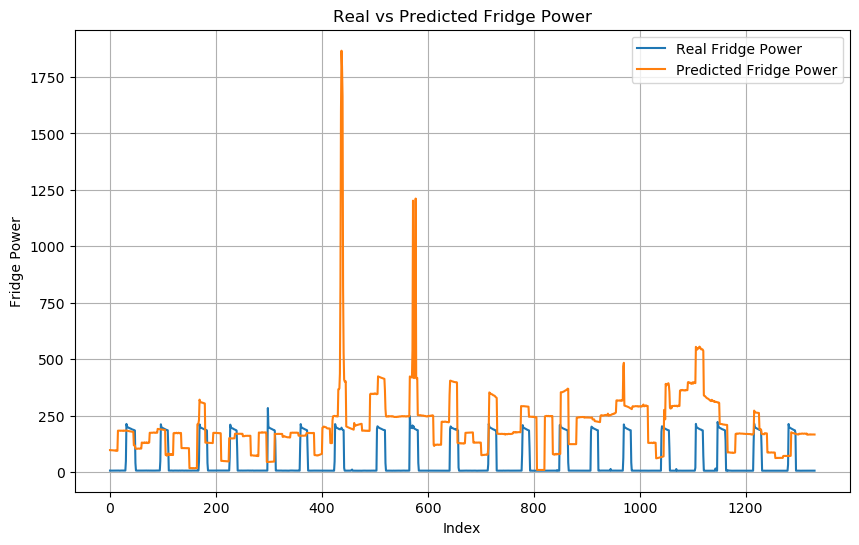

In [60]:
df_1 = pd.concat(pred_df_list, ignore_index=True)

# Assuming all_pred_df is defined elsewhere and contains the predicted values
all_pred_df = df_1.copy()  # Placeholder, replace with actual predicted values DataFrame

# Extract real and predicted fridge power
real_fridge_power = result_df['fridge_power'].values
predicted_fridge_power = all_pred_df['Fridge_power'].values

print(len(real_fridge_power))
print('PREDICTED',len(predicted_fridge_power))
# Plot results and calculate MSE
plot_results(real_fridge_power, predicted_fridge_power)


In [7]:

i=0
# Mock function to simulate API calls
def promptgroq_fewshots(csv, start_idx, chunksize, model, num_samples, initial_examples):
    answers = {'timestamps': [], 'predictions': []}
    attempts = 40
    predictions = []
    global api_keyover, client, i

    initial_examples_str = ", ".join(
    [f"Timestamp: {row['timestamp']}, Total Power: {row['total_power']}, Fridge Power: {row['fridge_power']}"
     for idx, row in initial_examples.iterrows()]
)


    def get_prediction(run, csv=csv, start_idx=start_idx, chunksize=chunksize, model=model):
        global i, api_keyover, client
        while i < attempts:
            try:
                completion = client.chat.completions.create(
                    model='llama3-8b-8192',
                    messages=[
                        # {
                        #     "role": "system",
                        #     "content": """You are a helpful assistant that performs time series predictions for NILM (Non-Intrusive Load Monitoring). The user will provide an aggregate data sequence of power consumption and timestamps with a few examples of power consumed by fridge, and you will predict the power consumption of the fridge corresponding to each timestamp in the data. The sequence is represented by decimal strings separated by commas for power values and ISO 8601 format for timestamps.
                                            
                        #                     DO NOT CHANGE THE TIMESTAMPS KEEP THEM SAME AS IN THE DATA.
                        #                     Fridge consumes a low amount of the aggregate power so predict accordingly. Also keep in mind the other appliances.
                        #                     Appliance Information:
                        #                     Low power consuming appliances - Lighting, Electronics, Fridge
                        #                     Moderate power consuming appliances - Bathroom GFI, Dishwasher, Microwave, Kitchen Outlets
                        #                     High power consuming appliances - Washer Dryer   
                        #                 """
                        # },
                        # {
                        #     "role": "user",
                        #     "content": f"""Predict the fridge power consumption for the given time series data for the next {chunksize} timestamps. Each timestamp in the input should have a corresponding output. Return your reply in the following format:
                        #                     [timestamp 0, prediction 0, timestamp 1, prediction 1, ..., timestamp {chunksize - 1}, prediction {chunksize - 1}] - the total length should be exactly {chunksize * 2}, starting from timestamp {start_idx} until the timestamp {start_idx + chunksize - 1}. Do not include any additional text or explanations.
                                            
                        #                     ### Initial Examples
                        #                     {initial_examples_str}

                        #                     ### Time Series Data
                        #                     {csv}
                        #                     """
                        # }
                        {
                            "role": "system",
                            "content": """You are a helpful assistant that performs time series predictions for NILM (Non-Intrusive Load Monitoring). The user will provide an aggregate data sequence of power consumption and timestamps with a few examples of power consumed by fridge, and you will predict the power consumption of the fridge corresponding to each timestamp in the data. The sequence is represented by decimal strings separated by commas for power values and ISO 8601 format for timestamps 
                                            DO NOT CHANGE THE TIMESTAMPS KEEP THEM SAME AS IN THE DATA. USE EXAMPLE STRING PROVIDED AS A TRAINING SET
                                            Fridge consumes a low amount of the aggregate power so predict accordingly. Also keep in mind the other appliances.
                                            Appliance Information:
                                            Low power consuming appliances - Lighting, Electronics, Fridge
                                            Moderate power consuming appliances - Bathroom GFI, Dishwasher, Microwave, Kitchen Outlets
                                            High power consuming appliances - Washer Dryer   
                                        """
                        },
                        {
                            "role": "user",
                            "content": f"""Predict the fridge power consumption for the given time series data for the next {chunksize} timestamps by using the examples provided. Each timestamp in the input should have a corresponding output. Return your reply in the following format:
                                            [timestamp 0, prediction 0, timestamp 1, prediction 1, ..., timestamp {chunksize - 1}, prediction {chunksize - 1}] - the total length should be exactly {chunksize * 2}, starting from timestamp {start_idx} until the timestamp {start_idx + chunksize - 1}. Do not include any additional text or explanations.
                                            
                                            ### Initial Examples
                                            {initial_examples_str}
                                            
                                            ### Time Series Data
                                            {csv}
                                            """
                        }
                    ],
                    temperature=1,
                    top_p=1,
                    stream=False,
                    stop=None,
                )
            except Exception as e:
                print('API key limit reached', e)
                api_keyover += 1
                client = Groq(api_key=api_keys[api_keyover % 4])
                continue

            try:
                answer = completion.choices[0].message.content.strip()
                predictions_list = [item.strip() for item in answer.split(',') if item.strip()]

                pred_timestamps = predictions_list[::2]
                pred_values_str = predictions_list[1::2]

                pred_values_cleaned = []
                for value in pred_values_str:
                    try:
                        pred_values_cleaned.append(float(value))
                    except ValueError:
                        float_part = ''.join([char for char in value if char.isdigit() or char == '.' or char == '-'])
                        pred_values_cleaned.append(float(float_part))

                pred_df = pd.DataFrame({
                    'timestamp': [ts.strip() for ts in pred_timestamps],
                    'predicted_fridge_power': pred_values_cleaned
                })

                if len(pred_timestamps) == chunksize:
                    return pred_df
                else:
                    i += 1
            except Exception as e:
                i += 1
                continue

        return None

    with concurrent.futures.ThreadPoolExecutor() as executor:
        future_to_run = {executor.submit(get_prediction, run): run for run in range(num_samples)}
        for future in tqdm(concurrent.futures.as_completed(future_to_run)):
            result = future.result()
            if result is not None:
                predictions.append(result)

    if len(predictions) < num_samples:
        return promptgroq(csv, start_idx, chunksize, model, num_samples, initial_examples)

    for i in range(chunksize):
        sum = 0
        for j in range(num_samples):
            sum += predictions[j]['predicted_fridge_power'][i]
        answers['predictions'].append(sum / num_samples)
        answers['timestamps'].append(predictions[0]['timestamp'][i])

    return answers




In [9]:
# Run the loop
for start_idx, chunksize in combinationstorun:
    for start in tqdm(range(0, len(test_df) - (start_idx + chunksize), 15)):
        current_chunk = test_df.iloc[start:start+start_idx+chunksize]
        input_string = current_chunk[['timestamp', 'total_power']].to_csv(index=False, header=False)
        input_string = input_string.replace(" ", "").replace('\n', ',').replace(',', ' , ')
        answer = promptgroq_fewshots(input_string, start + start_idx, chunksize, model, num_samples=2, initial_examples=initial_examples)
        predictions = answer['predictions']
        timestamps = answer['timestamps']
        predicted_df = pd.DataFrame({'Timestamp': timestamps, 'Fridge_power': predictions})
        print(predicted_df)
        pred_df_list.append(predicted_df)

2it [00:07,  3.91s/it][00:00<?, ?it/s]
  1%|          | 1/85 [00:07<10:59,  7.86s/it]

   Timestamp  Fridge_power
0     [01:00      6.675000
1      01:01      6.475000
2      01:02      6.662500
3      01:03      6.567708
4      01:04      6.583335
5      01:05      6.787500
6      01:06      6.625000
7      01:07      6.614583
8      01:08      6.633333
9      01:09      6.406250
10     01:10      6.843750
11     01:11      6.750000
12     01:12      6.500000
13     01:13      6.812500
14     01:14      6.831250


2it [00:01,  1.47it/s]
  2%|▏         | 2/85 [00:09<05:36,  4.05s/it]

   Timestamp  Fridge_power
0     [01:15       6.68750
1      01:16       6.59375
2      01:17       6.71875
3      01:18       6.62500
4      01:19       6.78125
5      01:20       6.62500
6      01:21       6.71875
7      01:22       6.62500
8      01:23       6.85000
9      01:24       6.71875
10     01:25       6.84375
11     01:26       6.81250
12     01:27       6.71875
13     01:28       6.71875
14     01:29       6.81250


2it [00:01,  1.51it/s]
  4%|▎         | 3/85 [00:10<03:51,  2.82s/it]

   Timestamp  Fridge_power
0     [01:30      6.750000
1      01:31      6.766667
2      01:32      6.812500
3      01:33      6.906250
4      01:34      6.875000
5      01:35     28.156250
6      01:36    104.883331
7      01:37    103.625000
8      01:38    102.687500
9      01:39    101.625000
10     01:40    100.406250
11     01:41     97.500000
12     01:42     97.050003
13     01:43     95.843750
14     01:44     97.343750


2it [00:09,  4.52s/it]
  5%|▍         | 4/85 [00:19<07:08,  5.29s/it]

   Timestamp  Fridge_power
0     [01:45       6.50000
1      01:46       6.46875
2      01:47       6.56250
3      01:48       6.50000
4      01:49       6.81250
5      01:50       6.25000
6      01:51       6.47500
7      01:52       6.50000
8      01:53       6.58750
9      01:54       6.50000
10     01:55       6.50000
11     01:56       6.47500
12     01:57       6.55625
13     01:58       6.70000
14     01:59       6.52500


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on tokens per minute (TPM): Limit 30000, Used 30389, Requested ~1713. Please try again in 4.203999999s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}
API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on tokens per minute (TPM): Limit 30000, Used 30777, Requested ~1713. Please try again in 4.98s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on tokens per minute (TPM): Limit 30000, Used 30431, Requested ~1713. Please try again in 4.288s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}


2it [00:37, 18.67s/it]
  6%|▌         | 5/85 [00:57<22:28, 16.86s/it]

   Timestamp  Fridge_power
0     [02:00      6.562500
1      02:01      6.437500
2      02:02      6.678750
3      02:03      6.463333
4      02:04      6.500000
5      02:05      6.812500
6      02:06      6.500000
7      02:07      6.561250
8      02:08      6.599500
9      02:09      6.311250
10     02:10      6.875000
11     02:11      6.750000
12     02:12      6.500000
13     02:13      6.750000
14     02:14      6.781250


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on tokens per minute (TPM): Limit 30000, Used 30040, Requested ~1712. Please try again in 3.505s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}


2it [00:27, 13.93s/it]
  7%|▋         | 6/85 [01:24<27:07, 20.60s/it]

   Timestamp  Fridge_power
0     [02:15      6.500000
1      02:16      6.437500
2      02:17      6.718750
3      02:18      6.625000
4      02:19      6.483333
5      02:20      6.500000
6      02:21      6.781250
7      02:22      6.781250
8      02:23      6.531250
9      02:24      6.593750
10     02:25      6.856250
11     02:26      6.750000
12     02:27      6.708333
13     02:28      6.812500
14     02:29      6.750000


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on tokens per minute (TPM): Limit 30000, Used 30178, Requested ~1714. Please try again in 3.784s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}


2it [00:19,  9.51s/it]
  8%|▊         | 7/85 [01:43<26:07, 20.09s/it]

   Timestamp  Fridge_power
0     [02:30      6.550000
1      02:31      6.509375
2      02:32      6.640625
3      02:33      6.718750
4      02:34      6.625000
5      02:35      6.643750
6      02:36      6.700000
7      02:37      6.781250
8      02:38      6.706250
9      02:39      6.675000
10     02:40      6.587500
11     02:41      6.762500
12     02:42      6.737500
13     02:43      6.693750
14     02:44      6.731250


2it [00:07,  3.88s/it]
  9%|▉         | 8/85 [01:51<20:45, 16.17s/it]

   Timestamp  Fridge_power
0     [02:45      6.187500
1      02:46      6.250000
2      02:47      6.250000
3      02:48      6.406250
4      02:49      6.406250
5      02:50      6.687500
6      02:51      6.625000
7      02:52      6.625000
8      02:53      6.625000
9      02:54      6.596667
10     02:55      6.625000
11     02:56      6.500000
12     02:57      6.562500
13     02:58      6.625000
14     02:59      6.625000


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on tokens per minute (TPM): Limit 30000, Used 29963, Requested ~1713. Please try again in 3.351s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on tokens per minute (TPM): Limit 30000, Used 30399, Requested ~1713. Please try again in 4.224s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}


2it [00:27, 13.90s/it]
 11%|█         | 9/85 [02:19<25:05, 19.81s/it]

   Timestamp  Fridge_power
0       [120    113.280300
1        121    112.986400
2        122    113.126550
3        123    113.010983
4        124    113.057650
5        125    113.158750
6        126    113.033750
7        127    113.048900
8        128    113.087500
9        129    112.968750
10       130    113.397500
11       131    113.360000
12       132    113.085000
13       133    113.426250
14       134    113.178333


2it [00:17,  8.96s/it]
 12%|█▏        | 10/85 [02:37<24:02, 19.24s/it]

   Timestamp  Fridge_power
0       [135      6.562500
1        136      6.468750
2        137      6.593750
3        138      6.483333
4        139      6.500000
5        140      6.656250
6        141      6.500000
7        142      6.531250
8        143      6.687500
9        144      6.625000
10       145      6.500000
11       146      6.656250
12       147      6.625000
13       148      6.500000
14       149      6.593750


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on tokens per minute (TPM): Limit 30000, Used 30498, Requested ~1711. Please try again in 4.418s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}
API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on tokens per minute (TPM): Limit 30000, Used 30058, Requested ~1711. Please try again in 3.538s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on tokens per minute (TPM): Limit 30000, Used 30384, Requested ~1711. Please try again in 4.191s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}


2it [00:54, 27.44s/it]
 13%|█▎        | 11/85 [03:32<37:11, 30.15s/it]

   Timestamp  Fridge_power
0       [150       6.71500
1        151       6.65375
2        152       6.71625
3        153       6.67000
4        154       6.68750
5        155       6.75000
6        156       6.75000
7        157       6.78125
8        158       6.62500
9        159       6.62500
10       160       6.62500
11       161       6.62500
12       162       6.62500
13       163       6.81875
14       164       6.78125


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on tokens per minute (TPM): Limit 30000, Used 30394, Requested ~1714. Please try again in 4.216999999s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}


2it [00:37, 18.69s/it]
 14%|█▍        | 12/85 [04:09<39:22, 32.36s/it]

   Timestamp  Fridge_power
0     [03:45      6.531250
1      03:46      6.500000
2      03:47      6.531250
3      03:48      6.531250
4      03:49      6.531250
5      03:50     27.750000
6      03:51    109.906250
7      03:52    104.383331
8      03:53    103.156250
9      03:54    102.187500
10     03:55    101.406250
11     03:56    101.156250
12     03:57    100.250000
13     03:58    100.093750
14     03:59     99.316666


2it [00:22, 11.45s/it]
 15%|█▌        | 13/85 [04:32<35:24, 29.50s/it]

   Timestamp  Fridge_power
0       [180      6.475000
1        181      6.468750
2        182      6.512500
3        183      6.485000
4        184      6.650000
5        185      6.600000
6        186      6.525000
7        187      6.623437
8        188      6.512500
9        189      6.737500
10       190      6.600000
11       191      6.543750
12       192      6.625000
13       193      6.641667
14       194      6.631250


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on tokens per minute (TPM): Limit 30000, Used 30413, Requested ~1713. Please try again in 4.253s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}


2it [00:18,  9.04s/it]
 16%|█▋        | 14/85 [04:50<30:50, 26.06s/it]

   Timestamp  Fridge_power
0     [04:15       6.25000
1      04:16       6.28125
2      04:17       6.37500
3      04:18       6.25000
4      04:19       6.31875
5      04:20       6.25000
6      04:21       6.65625
7      04:22       6.37500
8      04:23       6.37500
9      04:24       6.50000
10     04:25       6.59375
11     04:26       6.75000
12     04:27       6.62500
13     04:28       6.62500
14     04:29       6.75000


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on tokens per minute (TPM): Limit 30000, Used 30092, Requested ~1714. Please try again in 3.612s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}


2it [00:22, 11.18s/it]
 18%|█▊        | 15/85 [05:13<29:06, 24.95s/it]

   Timestamp  Fridge_power
0       [210      6.631250
1        211      6.562500
2        212      6.681250
3        213      6.606250
4        214      6.762500
5        215      6.675000
6        216      6.700000
7        217      6.664583
8        218      6.656250
9        219      6.681250
10       220      6.531250
11       221      6.781250
12       222      6.689583
13       223      6.731250
14       224      6.625000


2it [00:19,  9.74s/it]
 19%|█▉        | 16/85 [05:32<26:48, 23.31s/it]

   Timestamp  Fridge_power
0       [225     91.124000
1        226      6.052083
2        227     90.491250
3        228      6.600000
4        229     91.418333
5        230      6.716667
6        231     90.534268
7        232      6.575000
8        233     91.621250
9        234      6.593750
10       235     90.566870
11       236      6.745833
12       237     91.359690
13       238      6.658333
14       239     90.772585


2it [00:08,  4.07s/it]
 20%|██        | 17/85 [05:40<21:15, 18.76s/it]

   Timestamp  Fridge_power
0       [240      5.958333
1        241      5.958333
2        242      5.833333
3        243      5.958333
4        244      5.958333
5        245      5.833333
6        246      5.983333
7        247      5.958333
8        248      5.833333
9        249      5.958333
10       250      5.958333
11       251      5.833333
12       252      5.958333
13       253      5.983333
14       254      5.833333


2it [00:22, 11.42s/it]
 21%|██        | 18/85 [06:03<22:19, 19.99s/it]

   Timestamp  Fridge_power
0       [255        5.8750
1        256        6.1875
2        257        6.2500
3        258        6.3250
4        259        6.3250
5        260        6.2875
6        261        6.2250
7        262        6.2750
8        263        6.3250
9        264        6.3250
10       265        6.2750
11       266        6.2750
12       267        6.2750
13       268        6.2750
14       269        6.3250


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on tokens per minute (TPM): Limit 30000, Used 30187, Requested ~1712. Please try again in 3.799s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on tokens per minute (TPM): Limit 30000, Used 30238, Requested ~1712. Please try again in 3.9s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}


2it [00:27, 13.67s/it]
 22%|██▏       | 19/85 [06:31<24:25, 22.20s/it]

   Timestamp  Fridge_power
0     [05:30       6.00000
1      05:31       5.84375
2      05:32       6.00000
3      05:33       6.21875
4      05:34       5.87500
5      05:35       5.96875
6      05:36       6.00000
7      05:37       6.15625
8      05:38       6.00000
9      05:39       5.96875
10     05:40       6.00000
11     05:41       6.18750
12     05:42       6.00000
13     05:43       6.00000
14     05:44       6.09375


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on tokens per minute (TPM): Limit 30000, Used 30448, Requested ~1713. Please try again in 4.323s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on tokens per minute (TPM): Limit 30000, Used 30008, Requested ~1713. Please try again in 3.442s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}


2it [00:35, 17.80s/it]
 24%|██▎       | 20/85 [07:06<28:25, 26.24s/it]

   Timestamp  Fridge_power
0       [285       6.46875
1        286       6.46875
2        287       6.46875
3        288       6.57500
4        289       6.57500
5        290       6.57500
6        291       6.57500
7        292       6.57500
8        293       6.57500
9        294       6.70000
10       295       6.70000
11       296       6.70000
12       297       6.70000
13       298       6.70000
14       299       6.70000


2it [01:06, 33.14s/it]
 25%|██▍       | 21/85 [08:13<40:48, 38.26s/it]

   Timestamp  Fridge_power
0       [300      6.500000
1        301      6.481250
2        302      6.750000
3        303      6.531250
4        304      6.562500
5        305      6.537500
6        306      6.712500
7        307      6.791666
8        308      6.625000
9        309      6.562500
10       310      6.750000
11       311      6.583333
12       312      6.750000
13       313      6.550000
14       314      6.750000


2it [00:04,  2.04s/it]
 26%|██▌       | 22/85 [08:17<29:24, 28.01s/it]

   Timestamp  Fridge_power
0       [315       7.18750
1        316       7.12500
2        317       7.12500
3        318       7.12500
4        319       7.12500
5        320       7.12500
6        321       7.18750
7        322       7.12500
8        323       7.12500
9        324       7.15625
10       325       7.12500
11       326       7.18750
12       327       7.12500
13       328       7.12500
14       329       7.18750


2it [00:02,  1.09s/it]
 27%|██▋       | 23/85 [08:19<20:56, 20.27s/it]

   Timestamp  Fridge_power
0       [330       6.65850
1        331       6.50000
2        332       6.70000
3        333       6.45625
4        334       6.57500
5        335       6.65625
6        336       6.45000
7        337       6.57500
8        338       6.45000
9        339       6.57500
10       340       6.68750
11       341       6.57500
12       342       6.45000
13       343       6.57500
14       344       6.32500


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on tokens per minute (TPM): Limit 30000, Used 30089, Requested ~1714. Please try again in 3.606s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}


2it [00:28, 14.41s/it]
 28%|██▊       | 24/85 [08:48<23:12, 22.84s/it]

   Timestamp  Fridge_power
0       [345           6.5
1        346           6.5
2        347           6.5
3        348           6.5
4        349           6.5
5        350           6.5
6        351           6.5
7        352           6.5
8        353           6.5
9        354           6.5
10       355           6.5
11       356           6.5
12       357           6.5
13       358           6.5
14       359           6.5


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on tokens per minute (TPM): Limit 30000, Used 30495, Requested ~1712. Please try again in 4.415s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}
API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on tokens per minute (TPM): Limit 30000, Used 29940, Requested ~1712. Please try again in 3.304s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on tokens per minute (TPM): Limit 30000, Used 30299, Requested ~1712. Please try again in 4.022s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}


2it [00:40, 20.44s/it]
 29%|██▉       | 25/85 [09:29<28:15, 28.26s/it]

   Timestamp  Fridge_power
0     [07:00      6.612500
1      07:01      6.485417
2      07:02      6.687500
3      07:03      6.489583
4      07:04      6.625000
5      07:05      6.656250
6      07:06      6.550000
7      07:07      6.450000
8      07:08      6.675000
9      07:09      6.300000
10     07:10      6.625000
11     07:11      6.675000
12     07:12      6.612500
13     07:13      6.550000
14     07:14      6.625000


2it [00:13,  6.84s/it]
 31%|███       | 26/85 [09:42<23:29, 23.89s/it]

   Timestamp  Fridge_power
0     [07:15      6.531250
1      07:16      6.531250
2      07:17      6.656250
3      07:18      6.656250
4      07:19      6.593750
5      07:20      6.625000
6      07:21      6.775000
7      07:22      6.718750
8      07:23      6.500000
9      07:24      6.531250
10     07:25      6.775000
11     07:26      6.697917
12     07:27      6.625000
13     07:28      6.687500
14     07:29      6.750000


2it [00:09,  4.69s/it]
 32%|███▏      | 27/85 [09:52<18:53, 19.55s/it]

   Timestamp  Fridge_power
0       [390       6.46875
1        391       6.56250
2        392       6.52500
3        393       6.50000
4        394       6.50000
5        395       6.50000
6        396       6.62500
7        397       6.50000
8        398       6.50000
9        399       6.50000
10       400       6.50000
11       401       6.50000
12       402       6.50000
13       403       6.50000
14       404       6.50000


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on tokens per minute (TPM): Limit 30000, Used 30429, Requested ~1714. Please try again in 4.285999999s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}


2it [00:37, 18.74s/it]
 33%|███▎      | 28/85 [10:29<23:41, 24.93s/it]

   Timestamp  Fridge_power
0       [405      6.625000
1        406      6.437500
2        407      6.687500
3        408      6.466667
4        409      6.468750
5        410      6.812500
6        411      6.531250
7        412      6.656250
8        413      6.468750
9        414      6.687500
10       415      6.666667
11       416      6.750000
12       417      6.750000
13       418      6.562500
14       419      6.756250


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on tokens per minute (TPM): Limit 30000, Used 30132, Requested ~1713. Please try again in 3.691s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}
API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on tokens per minute (TPM): Limit 30000, Used 30156, Requested ~1713. Please try again in 3.738s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on tokens per minute (TPM): Limit 30000, Used 30149, Requested ~1713. Please try again in 3.724s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}


2it [01:03, 31.52s/it]
 34%|███▍      | 29/85 [11:32<33:56, 36.36s/it]

   Timestamp  Fridge_power
0       [420       6.50000
1        421       6.50000
2        422       6.53125
3        423       6.50000
4        424       6.50000
5        425       6.50000
6        426       6.50000
7        427       6.56250
8        428       6.50000
9        429       6.50000
10       430       6.50000
11       431       6.56250
12       432       6.50000
13       433       6.50000
14       434       6.50000


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on tokens per minute (TPM): Limit 30000, Used 30178, Requested ~1713. Please try again in 3.783s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}


2it [00:26, 13.49s/it]
 35%|███▌      | 30/85 [11:59<30:45, 33.55s/it]

   Timestamp  Fridge_power
0       [435      6.906250
1        436      6.812500
2        437      6.937500
3        438      6.827083
4        439      6.843750
5        440      6.968750
6        441      6.812500
7        442      6.843750
8        443      6.968750
9        444      6.812500
10       445      6.968750
11       446      6.812500
12       447      6.937500
13       448      7.000000
14       449      6.843750


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on tokens per minute (TPM): Limit 30000, Used 30227, Requested ~1712. Please try again in 3.879s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}


2it [00:19,  9.50s/it]
 36%|███▋      | 31/85 [12:18<26:16, 29.20s/it]

   Timestamp  Fridge_power
0       [450       6.46875
1        451       6.53125
2        452       6.59375
3        453       6.50000
4        454       6.56250
5        455       6.50000
6        456       6.62500
7        457       6.50000
8        458       6.50000
9        459       6.50000
10       460       6.50000
11       461       6.50000
12       462       6.62500
13       463       6.68750
14       464       6.62500


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on tokens per minute (TPM): Limit 30000, Used 30135, Requested ~1713. Please try again in 3.696s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}


2it [00:13,  6.71s/it]
 38%|███▊      | 32/85 [12:32<21:36, 24.47s/it]

   Timestamp  Fridge_power
0     [08:45      7.404445
1      08:46      7.374306
2      08:47      7.352500
3      08:48      7.628750
4      08:49      7.610000
5      08:50      7.476250
6      08:51      7.498500
7      08:52      7.525000
8      08:53      7.504750
9      08:54      7.436875
10     08:55      7.468750
11     08:56      7.496375
12     08:57      7.473125
13     08:58      7.487750
14     08:59      7.473000


2it [00:27, 13.55s/it]
 39%|███▉      | 33/85 [12:59<21:54, 25.28s/it]

   Timestamp  Fridge_power
0       [480      6.562500
1        481      6.500000
2        482      6.675000
3        483      6.608333
4        484      6.656250
5        485      6.737500
6        486      6.625000
7        487      6.531250
8        488      6.612500
9        489      6.468750
10       490      6.812500
11       491      6.625000
12       492      6.625000
13       493      6.643750
14       494      6.583333


2it [00:14,  7.16s/it]
 40%|████      | 34/85 [13:14<18:47, 22.10s/it]

   Timestamp  Fridge_power
0       [495      6.843750
1        496      6.700000
2        497      6.625000
3        498      6.787500
4        499      6.608333
5        500      6.737500
6        501      6.750000
7        502      6.575000
8        503      6.741667
9        504      6.600000
10       505      6.700000
11       506      6.741667
12       507      6.712500
13       508      6.725000
14       509      6.725000


2it [00:12,  6.05s/it]
 41%|████      | 35/85 [13:26<15:55, 19.11s/it]

   Timestamp  Fridge_power
0       [510      6.625000
1        511      6.537500
2        512      6.693750
3        513      6.708333
4        514      6.631250
5        515      6.731250
6        516      6.656250
7        517      6.750000
8        518      6.781250
9        519      6.781250
10       520      6.718750
11       521      6.781250
12       522      6.718750
13       523      6.750000
14       524      6.750000


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on tokens per minute (TPM): Limit 30000, Used 30086, Requested ~1712. Please try again in 3.596s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}


2it [00:54, 27.01s/it]
 42%|████▏     | 36/85 [14:20<24:10, 29.60s/it]

   Timestamp  Fridge_power
0     [09:45      4.687500
1      09:46      4.593750
2      09:47      4.718750
3      09:48      4.608333
4      09:49      4.625000
5      09:50      4.781250
6      09:51      4.625000
7      09:52      4.656250
8      09:53      4.750000
9      09:54      4.687500
10     09:55      4.781250
11     09:56      4.812500
12     09:57      4.625000
13     09:58      4.687500
14     09:59      4.656250


2it [00:09,  4.83s/it]
 44%|████▎     | 37/85 [14:29<18:54, 23.63s/it]

   Timestamp  Fridge_power
0       [540      6.000000
1        541      6.000000
2        542      5.968750
3        543      6.093750
4        544      6.000000
5        545      6.083333
6        546      6.000000
7        547      6.056250
8        548      6.000000
9        549      6.000000
10       550      6.000000
11       551      6.000000
12       552      6.000000
13       553      6.000000
14       554      6.000000


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on tokens per minute (TPM): Limit 30000, Used 30167, Requested ~1715. Please try again in 3.765s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}
API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on tokens per minute (TPM): Limit 30000, Used 30187, Requested ~1715. Please try again in 3.805s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on tokens per minute (TPM): Limit 30000, Used 30228, Requested ~1715. Please try again in 3.887s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}


2it [00:31, 15.71s/it]
 45%|████▍     | 38/85 [15:01<20:27, 26.11s/it]

   Timestamp  Fridge_power
0       [555      6.468750
1        556      6.468750
2        557      6.687500
3        558      6.531250
4        559      6.734375
5        560      6.500000
6        561      6.687500
7        562      6.625000
8        563      6.750000
9        564      6.781250
10       565      6.625000
11       566      6.781250
12       567      6.468750
13       568      6.625000
14       569      6.531250


2it [00:22, 11.40s/it]
 46%|████▌     | 39/85 [15:24<19:16, 25.14s/it]

   Timestamp  Fridge_power
0       [570      6.468750
1        571      6.531250
2        572      6.562500
3        573      6.500000
4        574      6.662500
5        575      6.687500
6        576      6.500000
7        577      6.500000
8        578      6.625000
9        579      6.583333
10       580      6.375000
11       581      6.406250
12       582      6.500000
13       583      6.656250
14       584      6.583333


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on tokens per minute (TPM): Limit 30000, Used 30218, Requested ~1712. Please try again in 3.861s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}


2it [00:17,  9.00s/it]
 47%|████▋     | 40/85 [15:42<17:16, 23.04s/it]

   Timestamp  Fridge_power
0       [585      6.645833
1        586      6.552083
2        587      6.677083
3        588      6.566667
4        589      6.583333
5        590      6.739583
6        591      6.583333
7        592      6.614583
8        593      6.645833
9        594      6.677083
10       595      6.558333
11       596      6.583333
12       597      6.645833
13       598      6.677083
14       599      6.583333


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on tokens per minute (TPM): Limit 30000, Used 30128, Requested ~1713. Please try again in 3.682s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}


2it [00:27, 13.88s/it]
 48%|████▊     | 41/85 [16:11<18:03, 24.64s/it]

   Timestamp  Fridge_power
0     [11:00    209.440300
1      11:01    208.576570
2      11:02    133.049375
3      11:03    125.700750
4      11:04    245.054060
5      11:05    126.370000
6      11:06    125.618750
7      11:07    132.583130
8      11:08    127.619380
9      11:09    126.792000
10     11:10     93.110315
11     11:11     91.005310
12     11:12     92.151880
13     11:13     91.326875
14     11:14     91.015310


2it [00:13,  6.89s/it]
 49%|████▉     | 42/85 [16:25<15:20, 21.42s/it]

   Timestamp  Fridge_power
0       [615      6.250250
1        616      6.500000
2        617      6.605000
3        618      6.518750
4        619      6.641667
5        620      6.656250
6        621      6.500000
7        622      6.708333
8        623      6.500000
9        624      6.566667
10       625      6.550000
11       626      6.666666
12       627      6.541666
13       628      6.583333
14       629      6.687500


2it [00:45, 22.94s/it]
 51%|█████     | 43/85 [17:11<20:08, 28.78s/it]

   Timestamp  Fridge_power
0       [630      6.554688
1        631      6.459375
2        632      6.468750
3        633      6.453125
4        634      6.593750
5        635      6.500000
6        636      6.515625
7        637      6.531250
8        638      6.515625
9        639      6.500000
10       640      6.500000
11       641      6.500000
12       642      6.531250
13       643      6.500000
14       644      6.500000


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on tokens per minute (TPM): Limit 30000, Used 30405, Requested ~1714. Please try again in 4.238s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}


2it [00:17,  8.53s/it]
 52%|█████▏    | 44/85 [17:28<17:17, 25.30s/it]

   Timestamp  Fridge_power
0       [645       5.58125
1        646       5.44000
2        647       5.50000
3        648       5.41500
4        649       5.36500
5        650       5.40375
6        651       5.48375
7        652       5.44500
8        653       5.35500
9        654       5.38000
10       655       5.40000
11       656       5.38000
12       657       5.41500
13       658       5.44000
14       659       5.46000


2it [00:13,  6.96s/it]
 53%|█████▎    | 45/85 [17:42<14:37, 21.94s/it]

   Timestamp  Fridge_power
0       [660       6.53750
1        661       6.34375
2        662       6.58125
3        663       6.65625
4        664       6.61250
5        665       6.59375
6        666       6.40625
7        667       6.61875
8        668       6.62500
9        669       6.62500
10       670       6.59375
11       671       6.63750
12       672       6.63125
13       673       6.40625
14       674       6.53125


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on tokens per minute (TPM): Limit 30000, Used 29945, Requested ~1714. Please try again in 3.317s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}


2it [00:23, 11.57s/it]
 54%|█████▍    | 46/85 [18:05<14:30, 22.33s/it]

   Timestamp  Fridge_power
0     [12:15       6.59375
1      12:16       6.53125
2      12:17       6.59375
3      12:18       6.50000
4      12:19       6.50000
5      12:20       6.65625
6      12:21       6.62500
7      12:22       6.50000
8      12:23       6.62500
9      12:24       6.50000
10     12:25       6.56250
11     12:26       6.65625
12     12:27       6.62500
13     12:28       6.50000
14     12:29       6.62500


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on tokens per minute (TPM): Limit 30000, Used 30352, Requested ~1712. Please try again in 4.128s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}


2it [00:17,  8.95s/it]
 55%|█████▌    | 47/85 [18:23<13:18, 21.02s/it]

   Timestamp  Fridge_power
0       [690      6.625000
1        691      6.437500
2        692      6.718750
3        693      6.483333
4        694      6.500000
5        695      6.812500
6        696      6.500000
7        697      6.406250
8        698      6.562500
9        699      6.708333
10       700      6.812500
11       701      6.625000
12       702      6.718750
13       703      6.562500
14       704      6.500000


2it [00:13,  6.56s/it]
 56%|█████▋    | 48/85 [18:36<11:30, 18.67s/it]

   Timestamp  Fridge_power
0       [705       6.59375
1        706       6.55000
2        707       6.53125
3        708       6.71875
4        709       6.55625
5        710       6.63750
6        711       6.45625
7        712       6.53125
8        713       6.71875
9        714       6.73125
10       715       6.60000
11       716       6.52500
12       717       6.53125
13       718       6.63750
14       719       6.62500


2it [00:13,  6.95s/it]
 58%|█████▊    | 49/85 [18:50<10:21, 17.27s/it]

   Timestamp  Fridge_power
0       [720      6.583333
1        721      6.802083
2        722      6.708333
3        723      6.770833
4        724      6.583333
5        725      6.708333
6        726      6.583333
7        727      6.645833
8        728      6.708333
9        729      6.583333
10       730      6.708333
11       731      6.583333
12       732      6.708333
13       733      6.583333
14       734      6.770833


2it [00:13,  6.88s/it]
 59%|█████▉    | 50/85 [19:04<09:27, 16.23s/it]

   Timestamp  Fridge_power
0       [735      6.583333
1        736      6.583333
2        737      6.625000
3        738      6.531250
4        739      6.500000
5        740      6.583333
6        741      6.625000
7        742      6.562500
8        743      6.562500
9        744      6.500000
10       745      6.583333
11       746      6.625000
12       747      6.583333
13       748      6.500000
14       749      6.583333


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on tokens per minute (TPM): Limit 30000, Used 30139, Requested ~1712. Please try again in 3.703s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}


2it [00:37, 18.68s/it]
 60%|██████    | 51/85 [19:42<12:47, 22.58s/it]

   Timestamp  Fridge_power
0     [13:30       6.50000
1      13:31       6.46875
2      13:32       6.62500
3      13:33       6.53125
4      13:34       6.50000
5      13:35       6.61250
6      13:36       6.50000
7      13:37       6.65625
8      13:38       6.62500
9      13:39       6.62500
10     13:40       6.65625
11     13:41       6.50000
12     13:42       6.50000
13     13:43       6.53125
14     13:44       6.50000


2it [00:08,  4.39s/it]
 61%|██████    | 52/85 [19:50<10:08, 18.45s/it]

   Timestamp  Fridge_power
0       [765      6.550000
1        766      6.614583
2        767      6.625000
3        768      6.500000
4        769      6.625000
5        770      6.687500
6        771      6.708333
7        772      6.625000
8        773      6.718750
9        774      6.708333
10       775      6.625000
11       776      6.625000
12       777      6.500000
13       778      6.625000
14       779      6.625000


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on tokens per minute (TPM): Limit 30000, Used 30135, Requested ~1714. Please try again in 3.698s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}


2it [00:17,  8.92s/it]
 62%|██████▏   | 53/85 [20:08<09:45, 18.28s/it]

   Timestamp  Fridge_power
0       [780      6.165625
1        781      6.273438
2        782      6.218750
3        783      6.140625
4        784      6.093750
5        785      6.187500
6        786      6.218750
7        787      6.187500
8        788      6.187500
9        789      6.187500
10       790      6.218750
11       791      6.250000
12       792      6.156250
13       793      6.187500
14       794      6.125000


2it [00:10,  5.31s/it]
 64%|██████▎   | 54/85 [20:19<08:15, 15.99s/it]

   Timestamp  Fridge_power
0       [795      6.583333
1        796      6.575093
2        797      6.653125
3        798      6.708333
4        799      6.718750
5        800      6.750000
6        801      6.687500
7        802      6.687500
8        803      6.658333
9        804      6.818750
10       805      6.681250
11       806      6.662500
12       807      6.706250
13       808      6.725000
14       809      6.670833


2it [00:11,  5.88s/it]
 65%|██████▍   | 55/85 [20:31<07:22, 14.74s/it]

   Timestamp  Fridge_power
0       [810      6.562500
1        811      6.500000
2        812      6.656250
3        813      6.443750
4        814      6.537500
5        815      6.500000
6        816      6.677083
7        817      6.531250
8        818      6.625000
9        819      6.437500
10       820      6.531250
11       821      6.593750
12       822      6.625000
13       823      6.500000
14       824      6.750000


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on tokens per minute (TPM): Limit 30000, Used 30354, Requested ~1714. Please try again in 4.136s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}


2it [00:23, 11.88s/it]
 66%|██████▌   | 56/85 [20:54<08:26, 17.46s/it]

   Timestamp  Fridge_power
0       [825      6.343750
1        826      6.468750
2        827      6.687500
3        828      6.516667
4        829      6.437500
5        830      6.750000
6        831      6.718750
7        832      6.500000
8        833      6.656250
9        834      6.656250
10       835      6.625000
11       836      6.812500
12       837      6.625000
13       838      6.500000
14       839      6.562500


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on tokens per minute (TPM): Limit 30000, Used 30355, Requested ~1713. Please try again in 4.136999999s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}


2it [00:18,  9.47s/it]
 67%|██████▋   | 57/85 [21:13<08:21, 17.92s/it]

   Timestamp  Fridge_power
0       [840      6.559375
1        841      6.564583
2        842      6.508333
3        843      6.433333
4        844      6.433333
5        845      6.483333
6        846      6.483333
7        847      6.545833
8        848      6.614583
9        849      6.583333
10       850      6.583333
11       851      6.583333
12       852      6.583333
13       853      6.583333
14       854      6.583333


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on tokens per minute (TPM): Limit 30000, Used 30269, Requested ~1712. Please try again in 3.962s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}


2it [00:35, 17.95s/it]
 68%|██████▊   | 58/85 [21:49<10:29, 23.32s/it]

   Timestamp  Fridge_power
0       [855      6.580000
1        856      6.536250
2        857      6.647500
3        858      6.518750
4        859      6.600000
5        860      6.796250
6        861      6.495000
7        862      6.596250
8        863      6.516667
9        864      6.688750
10       865      6.592500
11       866      6.560000
12       867      6.661667
13       868      6.710000
14       869      6.695000


2it [00:22, 11.20s/it]
 69%|██████▉   | 59/85 [22:12<09:59, 23.07s/it]

   Timestamp  Fridge_power
0       [870       6.62500
1        871       6.59375
2        872       6.59375
3        873       6.53125
4        874       6.53125
5        875       6.62500
6        876       6.65625
7        877       6.53125
8        878       6.59375
9        879       6.65625
10       880       6.62500
11       881       6.50000
12       882       6.56250
13       883       6.62500
14       884       6.65625


2it [00:38, 19.04s/it]
 71%|███████   | 60/85 [22:50<11:29, 27.58s/it]

   Timestamp  Fridge_power
0       [885      6.312500
1        886      6.218750
2        887      6.375000
3        888      6.234375
4        889      6.250000
5        890      6.375000
6        891      6.343750
7        892      6.375000
8        893      6.281250
9        894      6.406250
10       895      6.375000
11       896      6.450000
12       897      6.375000
13       898      6.375000
14       899      6.375000


2it [00:03,  1.64s/it]
 72%|███████▏  | 61/85 [22:53<08:07, 20.30s/it]

   Timestamp  Fridge_power
0       [914       6.43750
1        911       6.53125
2        908       6.65625
3        905       6.46875
4        902       6.56250
5        899       6.62500
6        896       6.59375
7        893       6.56250
8        890       6.50000
9        887       6.62500
10       884       6.62500
11       881       6.62500
12       878       6.65625
13       875       6.62500
14       872       6.65625


2it [00:05,  2.50s/it]
 73%|███████▎  | 62/85 [22:58<06:01, 15.72s/it]

   Timestamp  Fridge_power
0       [915      6.531250
1        916      6.645833
2        917      6.781250
3        918      6.562500
4        919      6.593750
5        920      6.625000
6        921      6.750000
7        922      6.718750
8        923      6.500000
9        924      6.562500
10       925      6.718750
11       926      6.812500
12       927      6.718750
13       928      6.645833
14       929      6.718750


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on tokens per minute (TPM): Limit 30000, Used 30169, Requested ~1713. Please try again in 3.765s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}


2it [00:39, 19.89s/it]
 74%|███████▍  | 63/85 [23:38<08:24, 22.95s/it]

   Timestamp  Fridge_power
0       [930      6.693750
1        931      6.658333
2        932      6.662500
3        933      6.658333
4        934      6.675000
5        935      6.600000
6        936      6.662500
7        937      6.658333
8        938      6.725000
9        939      6.662500
10       940      6.683333
11       941      6.731250
12       942      6.725000
13       943      6.683333
14       944      6.725000


API key limit reached Connection error.


2it [07:54, 237.39s/it]
 75%|███████▌  | 64/85 [31:33<55:28, 158.51s/it]

   Timestamp  Fridge_power
0       [945       5.75000
1        946       6.25000
2        947       6.28125
3        948       6.37500
4        949       6.25000
5        950       6.25000
6        951       6.31250
7        952       6.25000
8        953       6.25000
9        954       6.25000
10       955       6.25000
11       956       6.25000
12       957       6.25000
13       958       6.25000
14       959       6.25000


2it [00:03,  1.87s/it]
 76%|███████▋  | 65/85 [31:37<37:22, 112.10s/it]

   Timestamp  Fridge_power
0       [960      6.312500
1        961      6.400000
2        962      6.518750
3        963      6.762500
4        964      6.787500
5        965      6.708333
6        966      6.733333
7        967      6.758333
8        968      6.825000
9        969      6.850000
10       970      6.875000
11       971      6.900000
12       972      6.925000
13       973      6.950000
14       974      6.975000


2it [00:11,  5.64s/it]
 78%|███████▊  | 66/85 [31:48<25:55, 81.87s/it] 

   Timestamp  Fridge_power
0       [975      6.618750
1        976      6.506250
2        977      6.631250
3        978      6.541683
4        979      6.558350
5        980      6.706250
6        981      6.656250
7        982      6.681250
8        983      6.700000
9        984      6.556250
10       985      6.737500
11       986      6.725000
12       987      6.600000
13       988      6.756250
14       989      6.725000


2it [00:08,  4.35s/it]
 79%|███████▉  | 67/85 [31:57<17:58, 59.92s/it]

   Timestamp  Fridge_power
0       [990       5.78750
1        991       6.27500
2        992       6.37500
3        993       5.77500
4        994       6.31250
5        995       6.27500
6        996       5.82500
7        997       6.28125
8        998       6.30000
9        999       5.77500
10      1000       6.30000
11      1001       6.27500
12      1002       5.82500
13      1003       6.30000
14      1004       6.31250


2it [00:09,  4.97s/it]
 80%|████████  | 68/85 [32:07<12:43, 44.94s/it]

   Timestamp  Fridge_power
0      [1005       5.96875
1       1006       6.03125
2       1007       5.87500
3       1008       5.84375
4       1009       6.00000
5       1010       5.96875
6       1011       5.87500
7       1012       5.71875
8       1013       6.00000
9       1014       5.84375
10      1015       5.84375
11      1016       5.84375
12      1017       5.87500
13      1018       5.84375
14      1019       5.75000


2it [00:07,  3.85s/it]
 81%|████████  | 69/85 [32:15<09:00, 33.78s/it]

   Timestamp  Fridge_power
0      [1020      6.600000
1       1021      6.512500
2       1022      6.650000
3       1023      6.525000
4       1024      6.375000
5       1025      6.575000
6       1026      6.425000
7       1027      6.516666
8       1028      6.462500
9       1029      6.631250
10      1030      6.487500
11      1031      6.375000
12      1032      6.462500
13      1033      6.600000
14      1034      6.687500


2it [00:13,  6.76s/it]
 82%|████████▏ | 70/85 [32:28<06:55, 27.71s/it]

   Timestamp  Fridge_power
0      [1035      6.550000
1       1036      6.468749
2       1037      6.718750
3       1038      6.452083
4       1039      6.583333
5       1040      6.656250
6       1041      6.531250
7       1042      6.656250
8       1043      6.593750
9       1044      6.708333
10      1045      6.687500
11      1046      6.781250
12      1047      6.625000
13      1048      6.656250
14      1049      6.687500


2it [00:09,  4.99s/it]
 84%|████████▎ | 71/85 [32:38<05:13, 22.41s/it]

   Timestamp  Fridge_power
0      [1050      6.425000
1       1051      6.437500
2       1052      6.600000
3       1053      6.475000
4       1054      6.250000
5       1055      6.512500
6       1056      6.375000
7       1057      6.450000
8       1058      6.550000
9       1059      6.425000
10      1060      6.391666
11      1061      6.387500
12      1062      6.400000
13      1063      6.475000
14      1064      6.412500


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on tokens per minute (TPM): Limit 30000, Used 30037, Requested ~1714. Please try again in 3.502s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}


2it [00:13,  6.78s/it]
 85%|████████▍ | 72/85 [32:52<04:17, 19.78s/it]

   Timestamp  Fridge_power
0     [18:45      6.487500
1      20:20      6.443750
2      20:21      6.618750
3      20:22      6.558333
4      20:23      6.625000
5      20:24      6.831250
6      20:25      6.631250
7      20:26      6.962500
8      20:27      6.825000
9      20:28      6.937500
10     20:29      6.987500
11     20:30      7.100000
12     20:31      6.900000
13     20:32     27.825000
14     20:33    110.531250


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on tokens per minute (TPM): Limit 30000, Used 30562, Requested ~1715. Please try again in 4.554s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on tokens per minute (TPM): Limit 30000, Used 30074, Requested ~1715. Please try again in 3.579s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}


2it [00:27, 13.81s/it]
 86%|████████▌ | 73/85 [33:19<04:25, 22.16s/it]

   Timestamp  Fridge_power
0     [20:34      6.083334
1      20:35      6.083334
2      20:36      6.158334
3      20:37      6.183333
4      20:38      6.183333
5      20:39      6.208334
6      20:40      6.220834
7      20:41      6.208334
8      20:42      6.208334
9      20:43      6.208334
10     20:44      6.208334
11     20:45      6.208334
12     20:46      6.208334
13     20:47      6.195833
14     20:48      6.195833


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on tokens per minute (TPM): Limit 30000, Used 30126, Requested ~1710. Please try again in 3.672s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}


2it [00:13,  6.60s/it]
 87%|████████▋ | 74/85 [33:33<03:34, 19.53s/it]

   Timestamp  Fridge_power
0      [1095       6.40000
1       1096       6.46875
2       1097       6.58125
3       1098       6.67500
4       1099       6.81250
5       1100       6.64375
6       1101       6.50000
7       1102       6.51875
8       1103       6.55000
9       1104       6.65625
10      1105       6.75000
11      1106       6.59375
12      1107       6.50000
13      1108       6.57500
14      1109       6.65000


2it [00:09,  4.74s/it]
 88%|████████▊ | 75/85 [33:42<02:45, 16.53s/it]

   Timestamp  Fridge_power
0      [1110      5.687500
1       1111      5.468750
2       1112      5.718750
3       1113      5.483333
4       1114      5.625000
5       1115      5.656250
6       1116      5.625000
7       1117      5.531250
8       1118      5.675000
9       1119      5.406250
10      1120      5.812500
11      1121      5.625000
12      1122      5.625000
13      1123      5.500000
14      1124      5.656250


2it [00:14,  7.12s/it]
 89%|████████▉ | 76/85 [33:57<02:22, 15.85s/it]

   Timestamp  Fridge_power
0      [1125      6.516667
1       1126      6.500000
2       1127      6.500000
3       1128      6.500000
4       1129      6.500000
5       1130      6.500000
6       1131      6.500000
7       1132      6.500000
8       1133      6.500000
9       1134      6.500000
10      1135      6.500000
11      1136      6.500000
12      1137      6.500000
13      1138      6.500000
14      1139      6.500000


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on tokens per minute (TPM): Limit 30000, Used 30483, Requested ~1713. Please try again in 4.392s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}


2it [00:22, 11.14s/it]
 91%|█████████ | 77/85 [34:19<02:22, 17.79s/it]

   Timestamp  Fridge_power
0      [1140       6.47500
1       1141       6.45625
2       1142       6.47500
3       1143       6.44375
4       1144       6.47500
5       1145       6.50625
6       1146       6.47500
7       1147       6.47500
8       1148       6.44375
9       1149       6.47500
10      1150       6.47500
11      1151       6.47500
12      1152       6.47500
13      1153       6.47500
14      1154       6.47500


2it [00:18,  9.03s/it]
 92%|█████████▏| 78/85 [34:37<02:05, 17.88s/it]

   Timestamp  Fridge_power
0      [1155       6.56250
1       1156       6.46875
2       1157       6.59375
3       1158       6.62500
4       1159       6.65625
5       1160       6.75000
6       1161       6.50000
7       1162       6.50000
8       1163       6.53125
9       1164       6.37500
10      1165       6.37500
11      1166       6.43750
12      1167       6.40625
13      1168       6.50000
14      1169       6.50000


2it [00:13,  6.97s/it]
 93%|█████████▎| 79/85 [34:51<01:40, 16.71s/it]

   Timestamp  Fridge_power
0      [1170         6.525
1       1171         6.475
2       1172         6.525
3       1173         6.475
4       1174         6.425
5       1175         6.575
6       1176         6.500
7       1177         6.550
8       1178         6.600
9       1179         6.550
10      1180         6.525
11      1181         6.475
12      1182         6.425
13      1183         6.575
14      1184         6.500


2it [00:12,  6.49s/it]
 94%|█████████▍| 80/85 [35:04<01:18, 15.60s/it]

   Timestamp  Fridge_power
0      [1185      6.587500
1       1186      6.491667
2       1187      6.550000
3       1188      6.462500
4       1189      6.618750
5       1190      6.500000
6       1191      6.456250
7       1192      6.662500
8       1193      6.525000
9       1194      6.531250
10      1195      6.706250
11      1196      6.500000
12      1197      6.650000
13      1198      6.681250
14      1199      6.712500


2it [00:13,  6.98s/it]
 95%|█████████▌| 81/85 [35:18<01:00, 15.12s/it]

   Timestamp  Fridge_power
0      [1200      6.506250
1       1201      6.459375
2       1202      6.562500
3       1203      6.470833
4       1204      6.450000
5       1205      6.631250
6       1206      6.500000
7       1207      6.505000
8       1208      6.530000
9       1209      6.396250
10      1210      6.662500
11      1211      6.606250
12      1212      6.463750
13      1213      6.631250
14      1214      6.583333


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on tokens per minute (TPM): Limit 30000, Used 30736, Requested ~1713. Please try again in 4.899s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}
API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on tokens per minute (TPM): Limit 30000, Used 30376, Requested ~1713. Please try again in 4.179s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on tokens per minute (TPM): Limit 30000, Used 30145, Requested ~1713. Please try again in 3.717s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}


2it [00:55, 27.97s/it]
 96%|█████████▋| 82/85 [36:14<01:22, 27.37s/it]

   Timestamp  Fridge_power
0      [1215       6.48750
1       1216       6.46875
2       1217       6.65000
3       1218       6.55625
4       1219       6.58125
5       1220       6.47500
6       1221       6.62500
7       1222       6.65000
8       1223       6.55000
9       1224       6.47500
10      1225       6.52500
11      1226       6.64375
12      1227       6.47500
13      1228       6.52500
14      1229       6.55000


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on tokens per minute (TPM): Limit 30000, Used 30050, Requested ~1713. Please try again in 3.527s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}
API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on tokens per minute (TPM): Limit 30000, Used 30378, Requested ~1713. Please try again in 4.182s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on tokens per minute (TPM): Limit 30000, Used 30070, Requested ~1713. Please try again in 3.566s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}


2it [00:56, 28.18s/it]
 98%|█████████▊| 83/85 [37:10<01:12, 36.08s/it]

   Timestamp  Fridge_power
0      [1230      6.500000
1       1231      6.500000
2       1232      6.625000
3       1233      6.531250
4       1234      6.516667
5       1235      6.612500
6       1236      6.484375
7       1237      6.625000
8       1238      6.500000
9       1239      6.500000
10      1240      6.500000
11      1241      6.500000
12      1242      6.250000
13      1243      6.250000
14      1244      6.500000


2it [00:12,  6.36s/it]
 99%|█████████▉| 84/85 [37:23<00:29, 29.09s/it]

   Timestamp  Fridge_power
0      [1245      6.441250
1       1246      6.437500
2       1247      6.506250
3       1248      6.450000
4       1249      6.450000
5       1250      6.372917
6       1251      6.529167
7       1252      6.450000
8       1253      6.466667
9       1254      6.475000
10      1255      6.450000
11      1256      6.466667
12      1257      6.450000
13      1258      6.466667
14      1259      6.475000


2it [00:13,  6.91s/it]
100%|██████████| 85/85 [37:37<00:00, 26.56s/it]

   Timestamp  Fridge_power
0      [1260      6.531250
1       1261      6.514583
2       1262      6.625000
3       1263      6.562500
4       1264      6.468750
5       1265      6.468750
6       1266      6.500000
7       1267      6.612500
8       1268      6.625000
9       1269      6.593750
10      1270      6.525000
11      1271      6.500000
12      1272      6.656250
13      1273      6.625000
14      1274      6.500000
